In [5]:
# Dependencies
# conda create -n SEPA_env
# conda activate SEPA_env
# pip install kiwis-pie jupyterlab geopandas folium 
from datetime import date
from kiwis_pie import KIWIS
import geopandas as gp
import folium
import matplotlib.pyplot as plt

In [6]:
# Make initial connection using base API address
k = KIWIS('https://timeseries.sepa.org.uk/KiWIS/KiWIS')

In [7]:
file_location = '/media/Cheetah_1/Aux_folders/GIS/Forth/forth_catchment.geojson'
rio = gp.read_file(file_location)

<Axes: >

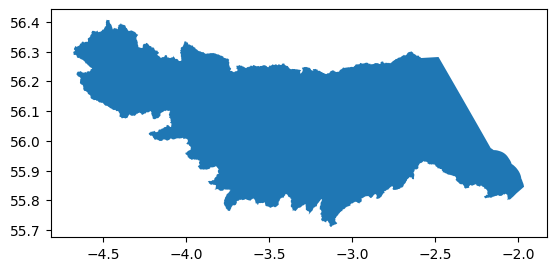

In [8]:
rio.plot()

In [9]:
# List of SEPA stations
station_list = k.get_station_list()

In [10]:
station_list

station_name station_no station_id station_latitude station_longitude
0    Abbey St Bathans      15018      36870      55.85329633      -2.387448356
1            Aberlour     234150      37132      57.48021805      -3.205975095
2          Aberuchill      14966      36730      56.37078118      -4.019153819
3          Aberuthven      14969      36744      56.31968188      -3.658685969
4            Abington     322551      37602      55.48691533       -3.69056827
..                ...        ...        ...              ...               ...
775      White Laggan     133180      36374      55.07382387      -4.401198238
776        Whitesands     133181      36378      55.06536955      -3.610749368
777          Wolfhill      15067      36920      56.48512657      -3.370467732
778           Woodend     234333      37558       57.0501291      -2.603567118
779          Woodfoot     133182      36382      55.29395422       -3.41903487

[780 rows x 5 columns]

In [11]:
# get rid of stations without lat lon
station_list = station_list.loc[station_list['station_latitude'] != '',]

# Turn stations into geopandas data frame
station_list = gp.GeoDataFrame(
    station_list, geometry=gp.points_from_xy(station_list.station_longitude, station_list.station_latitude))
station_list = station_list.set_crs(epsg=4326)

In [12]:
# Spatially join with region of interest using a point in polygon 
rio_stations = gp.sjoin(station_list,rio)
# Drop nuisance columns
rio_stations = rio_stations.drop(columns=['index_right','fid'])

In [13]:
# Plot 10 examples of stations within the Forth
rio_stations.head(70)

station_name station_no station_id  \
16                            Almondell      14869      36404   
22                                 Anie      14888      36462   
24                             Annfield      15198      37068   
33                       Athelstaneford     372871      37998   
37                          Auchentroig      15163      37032   
..                                  ...        ...        ...   
437                             Kinbuck      14890      36470   
441  Kinghorn Ecology Centre Rain Gauge     473550      38082   
449                             Kinross      14903      36506   
450                           Kirkcaldy     335617      37680   
456                        Kirkton Burn     116005      35952   

    station_latitude station_longitude                   geometry  
16       55.90181846      -3.463017734  POINT (-3.46302 55.90182)  
22       56.25788155      -4.285414699  POINT (-4.28541 56.25788)  
24       56.06640057      -3.371633207  POINT (-3.37163 56.06640)  
33        55.9852479      -2.736326688  POINT (-2.73633 55.98525)  
37       56.11221933      -4.342412217  POINT (-4.34241 56.11222)  
..               ...               ...                        ...  
437       56.2255551      -3.949530685  POINT (-3.94953 56.22556)  
441      56.07462319      -3.193432968  POINT (-3.19343 56.07462)  
449      56.19853589      -3.422943515  POINT (-3.42294 56.19854)  
450      56.11765342      -3.147961765  POINT (-3.14796 56.11765)  
456      56.36683432      -4.377397065  POINT (-4.37740 56.36683)  

[70 rows x 6 columns]

In [14]:
# Plot
# base = station_list.plot(marker='o', color='blue', markersize=1,figsize=(10,10))
# base = rio.plot(ax=base, color='#ffffff00', edgecolor='black')
# rio_stations.plot(ax=base, marker='*', color='red', markersize=6)

### Plot locations of stations

In [15]:
# create base map
map = folium.Map(location=[56.015991, -3.481558], zoom_start=9, control_scale=True)
folium.GeoJson(file_location, name="geojson").add_to(map)
# iterate over stations and plot locations with markers
for index, location_info in rio_stations.iterrows():
    folium.Marker([location_info["station_latitude"], location_info["station_longitude"]], popup=location_info["station_name"]).add_to(map)
map

### List of available variables

In [16]:
# station parameters 'Flow', 'Rain', 'Level'
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values)
# List all relevant parameters
parameters_list['stationparameter_name'].unique().tolist()

['Level', 'Flow', 'Rain', 'GroundwaterLevel', 'TidalLevel']

### Filter by river level and plot

In [17]:
# We are interested in just water level for this exercise so return only those results
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name='Level')
print(parameters_list.shape)
parameters_list.head()

(52, 6)


station_name station_no station_id parametertype_id parametertype_name  \
0     Kirkton Burn     116005      35952              560                  S   
1  Lower Monachyle     116006      35956              560                  S   
2  Upper Monachyle     116007      35960              560                  S   
3         Luffness      14865      36390              560                  S   
4      Craigiehall      14867      36396              560                  S   

  stationparameter_name  
0                 Level  
1                 Level  
2                 Level  
3                 Level  
4                 Level

In [18]:
# Select only station data for relevant ids within the forth
rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
#rio_stations_par.to_excel("C:\\Users\\crs2\\Desktop\\SEPA_API_tests\\Level.xlsx")
# plot
map = folium.Map(location=[56.015991, -3.481558], zoom_start=9, control_scale=True)
# iterate over stations and plot locations with markers
for index, location_info in rio_stations_par.iterrows():
    folium.Marker([location_info["station_latitude"], location_info["station_longitude"]], popup=location_info["station_name"]).add_to(map)
map

### Filter stations that measure rainfall and plot

In [19]:
# We are interested in just water level for this exercise so return only those results
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name='Rain')
# Select only station data for relevant ids within the forth
rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
# plot
map = folium.Map(location=[56.015991, -3.481558], zoom_start=9, control_scale=True)
# iterate over stations and plot locations with markers
for index, location_info in rio_stations_par.iterrows():
    folium.Marker([location_info["station_latitude"], location_info["station_longitude"]], popup=location_info["station_name"]).add_to(map)
map

### Tidal Level

In [20]:
# We are interested in just water level for this exercise so return only those results
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name='TidalLevel')
# Select only station data for relevant ids within the forth
rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
# plot
map = folium.Map(location=[56.015991, -3.481558], zoom_start=9, control_scale=True)
# iterate over stations and plot locations with markers
for index, location_info in rio_stations_par.iterrows():
    folium.Marker([location_info["station_latitude"], location_info["station_longitude"]], popup=location_info["station_name"]).add_to(map)
map

### Ground water level

In [21]:
# We are interested in just water level for this exercise so return only those results
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name='GroundwaterLevel')
# Select only station data for relevant ids within the forth
rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
# plot
map = folium.Map(location=[56.015991, -3.481558], zoom_start=9, control_scale=True)
# iterate over stations and plot locations with markers
for index, location_info in rio_stations_par.iterrows():
    folium.Marker([location_info["station_latitude"], location_info["station_longitude"]], popup=location_info["station_name"]).add_to(map)
map

### Explore which data we can get for each variable measured

In [22]:
def get_available_time_series(stationparameter_name):
    # Check out the different time series interval options for a specific station parameter names
    parameters_list =k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name=stationparameter_name)
    # Select only station data for relevant ids within the forth
    rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
    time_series_options = k.get_timeseries_list(station_id = rio_stations_par.station_id,stationparameter_name=stationparameter_name)['ts_name'].unique().tolist()
    return(time_series_options)

In [23]:
stationparameter_name = 'Level'
get_available_time_series(stationparameter_name)

['HydrologicalYear.Mean',
 'Month.Max',
 'CalendarYear.Max',
 'Month.Mean',
 'CalendarYear.Min',
 'HydrologicalYear.Max',
 'HydrologicalYear.Min',
 'LongTermValue.Month.Max',
 'LongTermValue.Month.Mean',
 'CalendarYear.Mean',
 'Month.Min',
 'Day.Min',
 'LongTermValue.Month.Min',
 'Day.Mean',
 '15minute',
 'Day.Max',
 'PeaksOverThreshold',
 'LongTermValue.Mean.HydMonth.Max',
 'LongTermValue.Mean.HydMonth.Min',
 'LongTermValue.Mean.HydYear.Max',
 'LongTermValue.Max.HydYear.Max']

In [24]:
stationparameter_name = 'Rain'
get_available_time_series(stationparameter_name)

['LongTermValue.Month.Mean',
 'HydrologicalYear.Total',
 'LongTermValue.Month.Max',
 'Month.Total',
 'LongTermValue.Month.Min',
 'Day.Total',
 'CalendarYear.Total',
 'Hour.Total',
 'Hour.36HourTotal',
 '15minute.Total']

In [25]:
stationparameter_name = 'Flow'
get_available_time_series(stationparameter_name)

['Gaugings',
 '15minute',
 'Day.Mean',
 'PeaksOverThreshold',
 'HydrologicalYear.Max']

In [26]:
stationparameter_name = 'TidalLevel'
get_available_time_series(stationparameter_name)

['Day.Max',
 'LongTermValue.Month.Min',
 'Month.Max',
 'Month.Min',
 'CalendarYear.Max',
 'CalendarYear.Mean',
 'MeanWater',
 'CalendarYear.Min',
 'HydrologicalYear.Min',
 'Day.Mean',
 'LowWater',
 'Month.Mean',
 'Day.Min',
 'HydrologicalYear.Mean',
 '15minute',
 'HighWater',
 'LongTermValue.Month.Max',
 'LongTermValue.Month.Mean',
 'HydrologicalYear.Max']

In [27]:
stationparameter_name = 'GroundwaterLevel'
get_available_time_series(stationparameter_name)

['LongTermValue.Month.Mean',
 'CalendarYear.Mean',
 'Day.Max',
 'LongTermValue.Month.Max',
 'Month.Mean',
 'HydrologicalYear.Max',
 'CalendarYear.Max',
 'CalendarYear.Min',
 'HydrologicalYear.Min',
 'LongTermValues.Month.Min',
 'Month.Min',
 'Day.Min',
 'Hour',
 'Month.Max',
 'HydrologicalYear.Mean',
 'Day.Mean']

In [28]:
# # Look at the documentation for defining returned column headers https://kiwis-pie.readthedocs.io/en/latest/api/kiwis_pie.html#module-kiwis_pie.kiwis
# headers=['station_name','station_no','station_id','ts_id','ts_name','parametertype_id','parametertype_name',
#          'stationparameter_name','stationparameter_longname','ts_density','ts_unitname','ts_unitsymbol','coverage']

# # return ts ids for stations, parameters and time series interval options selected
# #ts_frame = k.get_timeseries_list(station_id = rio_stations_par.station_id, stationparameter_name='Level',ts_name='Day.Mean',return_fields=headers)
# ts_frame = k.get_timeseries_list(station_id = rio_stations_par.station_id, stationparameter_name='Rain',ts_name='Day.Mean',return_fields=headers)

# # Just to check there are 50 time series datasets available for the stations, parameters and time series interval options selected
# print('Stations available for this variable: '+str(ts_frame.shape[0]))

# # Using Callander as demonstrator return ts_id of interest
# ts_of_interest = ts_frame.loc[ts_frame['station_name'] == 'Callander']['ts_id'].values[0] # time series ID
# # Get time series data
# timeseries_dataset = k.get_timeseries_values(ts_id = ts_of_interest, to = date(2022,5,31), **{'from': date(2018,1,1)})

# # Plot data - you can automate the addition of labels from metadata  
# ax = timeseries_dataset.plot(title='River water level Callander',figsize=(16,10))
# ax.set(xlabel="Date", ylabel="River Water level (m)")

### Get time series data for a given variable of a given station

In [29]:
rio_stations

station_name station_no station_id station_latitude  \
16            Almondell      14869      36404      55.90181846   
22                 Anie      14888      36462      56.25788155   
24             Annfield      15198      37068      56.06640057   
33       Athelstaneford     372871      37998       55.9852479   
37          Auchentroig      15163      37032      56.11221933   
..                  ...        ...        ...              ...   
741             Torduff      15190      37060       55.8968016   
749           Turnhouse      14883      36442      55.94528452   
753     Upper Monachyle     116007      35960      56.39271229   
770  Westwood Farm Lane      15169      37044      56.12907309   
772            Whitburn      14881      36432      55.87157334   

    station_longitude                   geometry  
16       -3.463017734  POINT (-3.46302 55.90182)  
22       -4.285414699  POINT (-4.28541 56.25788)  
24       -3.371633207  POINT (-3.37163 56.06640)  
33       -2.736326688  POINT (-2.73633 55.98525)  
37       -4.342412217  POINT (-4.34241 56.11222)  
..                ...                        ...  
741      -3.267160193  POINT (-3.26716 55.89680)  
749      -3.345442654  POINT (-3.34544 55.94528)  
753      -4.463706898  POINT (-4.46371 56.39271)  
770      -4.013078635  POINT (-4.01308 56.12907)  
772      -3.682936938  POINT (-3.68294 55.87157)  

[111 rows x 6 columns]

In [30]:
def get_SEPA_time_series(headers,parameter_name,ts_type,station,start,end):
    # Filter stations that measure parameter_name
    parameters_list =k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name=parameter_name)
    # Select only station data within the forth
    rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]
    # return timeseries 'ts_type' for parameter 'parameter_name' and time series interval options selected
    ts_frame = k.get_timeseries_list(station_id = rio_stations_par.station_id, stationparameter_name=parameter_name,ts_name=ts_type,return_fields=headers)

    # check No. of time series datasets available for the stations, parameters and time series interval options selected
    print('Stations available for '+parameter_name+': '+str(ts_frame.shape[0]))

    # filter dataframe by station name
    ts_of_interest = ts_frame.loc[ts_frame['station_name'] == station]['ts_id'].values[0] # time series ID
    # Get time series data
    timeseries_dataset = k.get_timeseries_values(ts_id = ts_of_interest, to = end, **{'from': start})
    return(timeseries_dataset)

In [31]:
# Plot in a separate window
#%matplotlib qt

Stations available for Level: 52
Stations available for Rain: 62


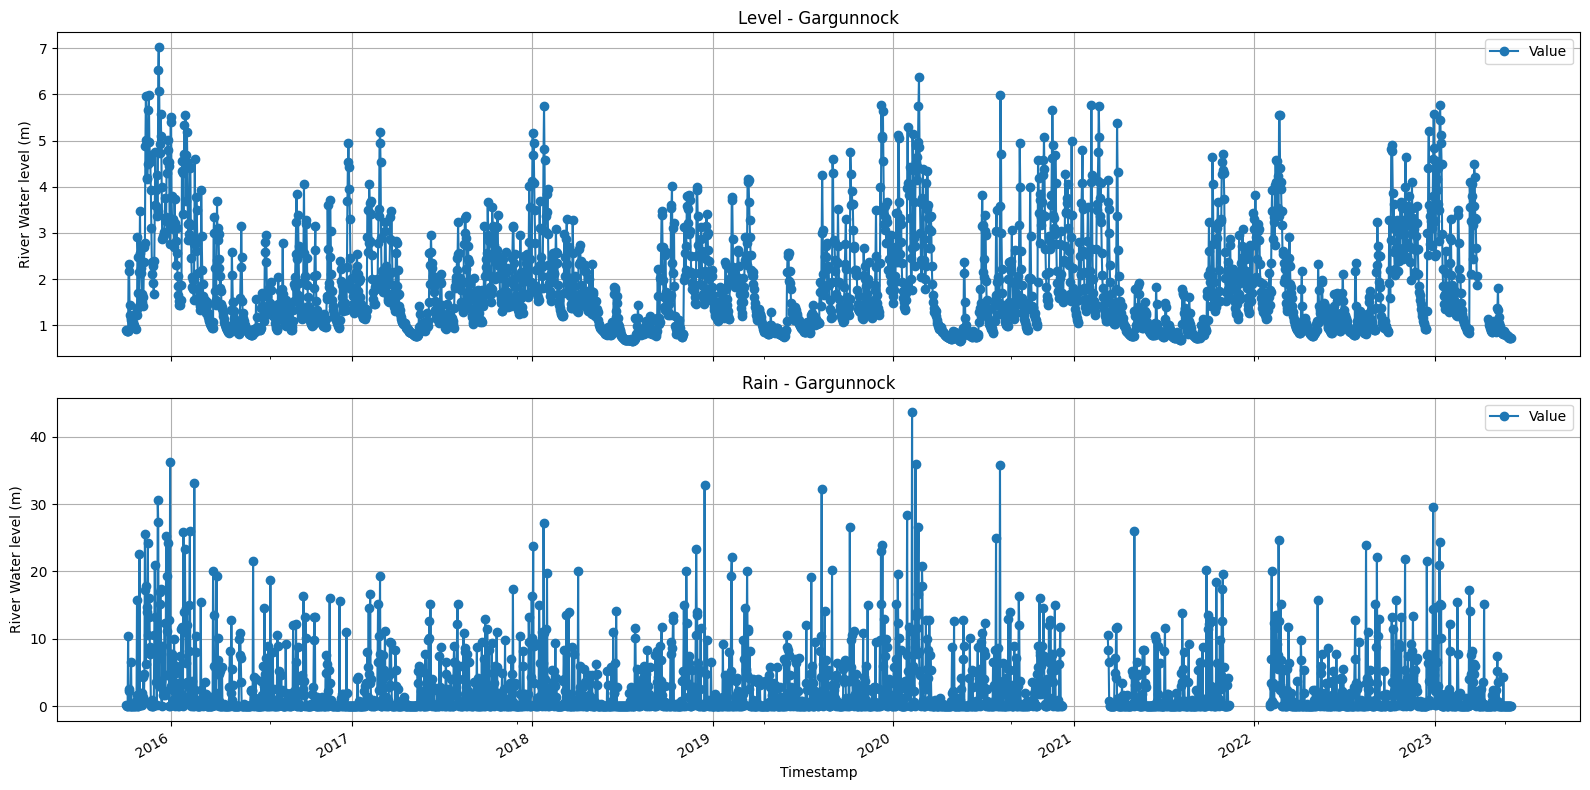

In [55]:
# Look at the documentation for defining returned column headers https://kiwis-pie.readthedocs.io/en/latest/api/kiwis_pie.html#module-kiwis_pie.kiwis
headers=['station_name','station_no','station_id','ts_id','ts_name','parametertype_id','parametertype_name',
         'stationparameter_name','stationparameter_longname','ts_density','ts_unitname','ts_unitsymbol','coverage']

station = 'Gargunnock'# 
#station = 'Strathyre'
#station = 'Craigforth'
ts_type = 'Day.Mean'
start = date(2015,10,1)
end=date.today()#date(2022,9,13) 

parameter_name = 'Level'
level_time_series = get_SEPA_time_series(headers,parameter_name,ts_type,station,start,end)

fig,((ax,ax1))=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(16,8))
level_time_series.plot(ax=ax,style="-o")
ax.set_title(parameter_name+' - '+station)
ax.set(ylabel="River Water level (m)")
ax.grid(True)
#station = 'Westwood Farm Lane'
#station='Sterling Mills Gauging Station'
#station = 'Bridge of Teith'
#station = 'Glenochil'
#parameter_name ='Flow' #
parameter_name ='Rain' #
ts_type = 'Day.Total'
rain_time_series = get_SEPA_time_series(headers,parameter_name,ts_type,station,start,end)

rain_time_series.plot(ax=ax1,style="-o")
ax1.set_title(parameter_name+' - '+station)
#ax1.set(xlabel="Date", ylabel="Rainfall")
ax1.set(ylabel="River Water level (m)")
ax1.grid(True)
plt.tight_layout()

In [53]:
import pandas as pd
pd.options.display.max_rows = 2000 #Changes the number of rows diplayed (default is 60)
rain_time_series.head(20)

Value
Timestamp                       
2015-10-01 09:00:00+00:00    0.2
2015-10-02 09:00:00+00:00    0.0
2015-10-03 09:00:00+00:00    0.0
2015-10-04 09:00:00+00:00    0.0
2015-10-05 09:00:00+00:00   10.4
2015-10-06 09:00:00+00:00    2.2
2015-10-07 09:00:00+00:00    2.6
2015-10-08 09:00:00+00:00    0.0
2015-10-09 09:00:00+00:00    0.0
2015-10-10 09:00:00+00:00    0.0
2015-10-11 09:00:00+00:00    6.6
2015-10-12 09:00:00+00:00    0.0
2015-10-13 09:00:00+00:00    0.0
2015-10-14 09:00:00+00:00    0.0
2015-10-15 09:00:00+00:00    0.2
2015-10-16 09:00:00+00:00    0.2
2015-10-17 09:00:00+00:00    0.0
2015-10-18 09:00:00+00:00    0.0
2015-10-19 09:00:00+00:00    0.0
2015-10-20 09:00:00+00:00    0.8

Text(0.5, 1.0, 'River level vs river flow')

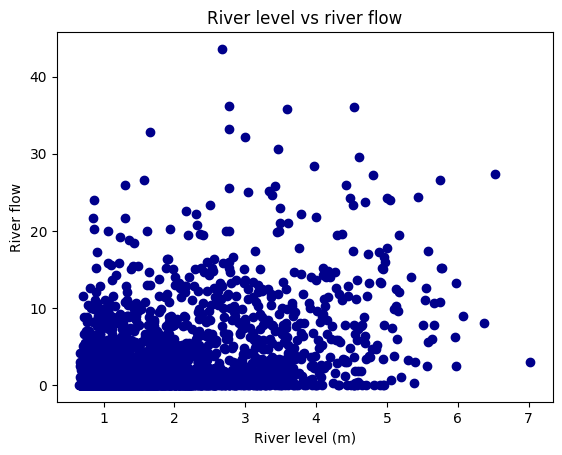

In [54]:
fig,ax1=plt.subplots()
ax1.scatter(x=level_time_series,y=rain_time_series,c='DarkBlue')
ax1.set(xlabel="River level (m)", ylabel="River flow")
plt.title('River level vs river flow')

<Axes: xlabel='Timestamp'>

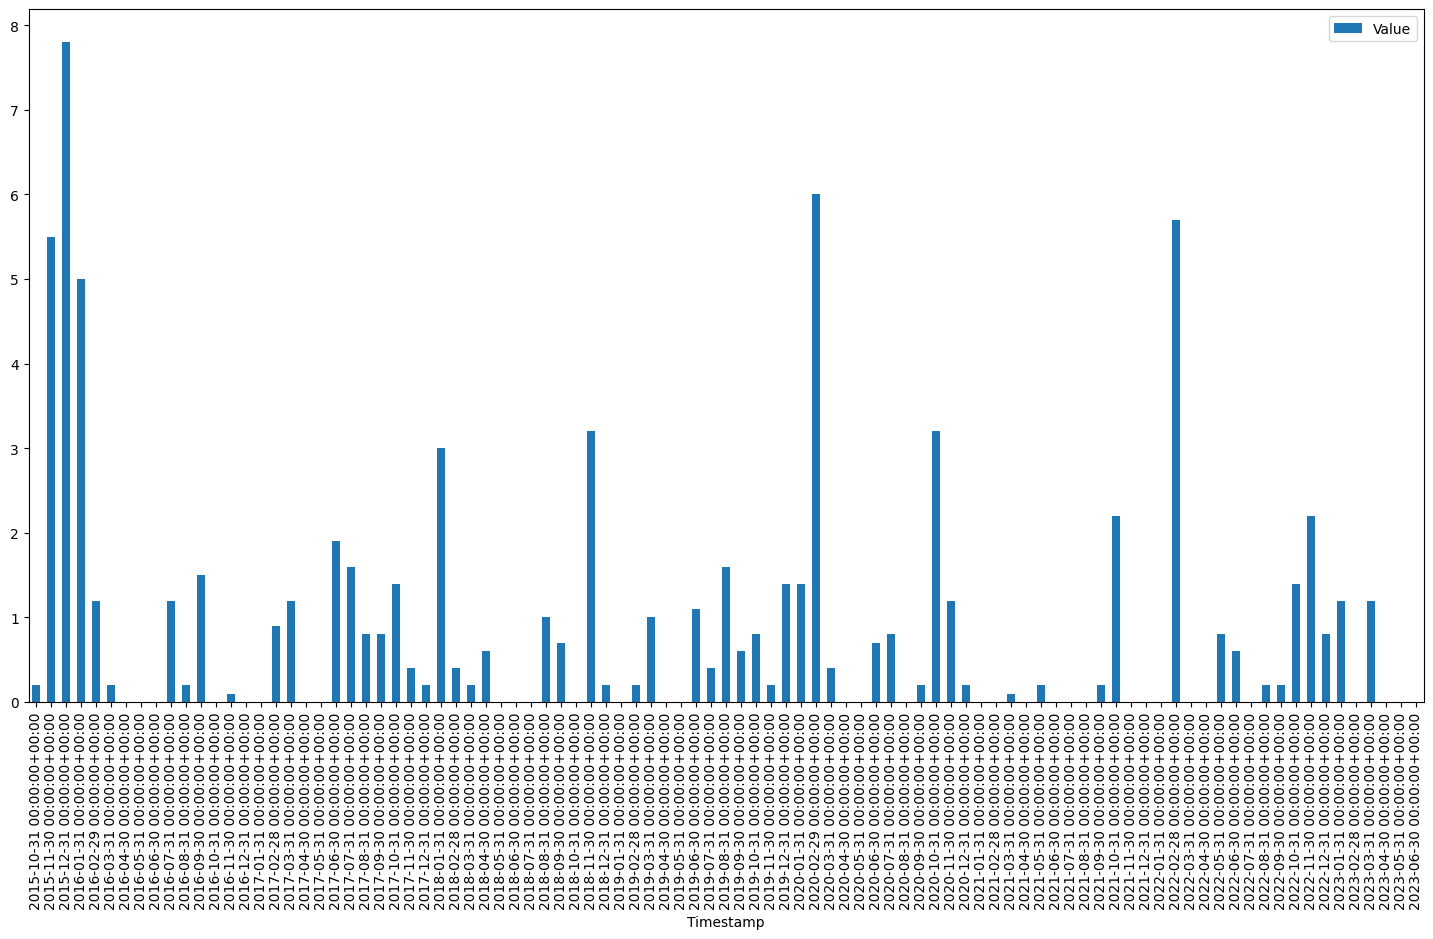

In [59]:
g = rain_time_series.groupby(pd.Grouper(freq="M")).median()
g.plot.bar(figsize=(18,9))

### Driest months

In [60]:
g[g.Value==g.min()[0]]

Value
Timestamp                       
2016-04-30 00:00:00+00:00    0.0
2016-05-31 00:00:00+00:00    0.0
2016-06-30 00:00:00+00:00    0.0
2016-10-31 00:00:00+00:00    0.0
2016-12-31 00:00:00+00:00    0.0
2017-01-31 00:00:00+00:00    0.0
2017-04-30 00:00:00+00:00    0.0
2017-05-31 00:00:00+00:00    0.0
2018-05-31 00:00:00+00:00    0.0
2018-06-30 00:00:00+00:00    0.0
2018-07-31 00:00:00+00:00    0.0
2018-10-31 00:00:00+00:00    0.0
2019-01-31 00:00:00+00:00    0.0
2019-04-30 00:00:00+00:00    0.0
2019-05-31 00:00:00+00:00    0.0
2020-04-30 00:00:00+00:00    0.0
2020-05-31 00:00:00+00:00    0.0
2020-08-31 00:00:00+00:00    0.0
2021-04-30 00:00:00+00:00    0.0
2021-06-30 00:00:00+00:00    0.0
2021-07-31 00:00:00+00:00    0.0
2021-08-31 00:00:00+00:00    0.0
2021-11-30 00:00:00+00:00    0.0
2022-03-31 00:00:00+00:00    0.0
2022-04-30 00:00:00+00:00    0.0
2022-07-31 00:00:00+00:00    0.0
2023-02-28 00:00:00+00:00    0.0
2023-04-30 00:00:00+00:00    0.0
2023-05-31 00:00:00+00:00    0.0
2023-06-30 00:00:00+00:00    0.0

In [61]:
rain_time_series.median()

Value    0.4
dtype: float64

### wetter months

In [68]:
#rain_time_series['Value']
rain_time_series[rain_time_series.Value >25]

Value
Timestamp                       
2015-11-08 09:00:00+00:00   25.6
2015-12-04 09:00:00+00:00   30.6
2015-12-05 09:00:00+00:00   27.4
2015-12-21 09:00:00+00:00   25.2
2015-12-29 09:00:00+00:00   36.2
2016-01-25 09:00:00+00:00   25.8
2016-02-07 09:00:00+00:00   26.0
2016-02-16 09:00:00+00:00   33.2
2018-01-23 09:00:00+00:00   27.2
2018-12-15 09:00:00+00:00   32.8
2019-08-09 09:00:00+00:00   32.2
2019-10-05 09:00:00+00:00   26.6
2020-01-29 09:00:00+00:00   28.4
2020-02-08 09:00:00+00:00   43.6
2020-02-15 09:00:00+00:00   36.0
2020-02-21 09:00:00+00:00   26.6
2020-08-04 09:00:00+00:00   35.8
2021-05-03 09:00:00+00:00   26.0
2022-12-29 09:00:00+00:00   29.6

In [39]:
station_name = 'Bridge of Allan'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id parametertype_name  \
0  Bridge of Allan      14889      36466              558                  Q   
1  Bridge of Allan      14889      36466              560                  S   

  stationparameter_name  
0                  Flow  
1                 Level

In [40]:
station_name='Gargunnock'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id parametertype_name  \
0   Gargunnock      14892      36480              523             Precip   
1   Gargunnock      14892      36480              558                  Q   
2   Gargunnock      14892      36480              560                  S   

  stationparameter_name  
0                  Rain  
1                  Flow  
2                 Level

In [41]:
station_name='Callander'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id parametertype_name  \
0    Callander      14911      36532              560                  S   

  stationparameter_name  
0                 Level

In [42]:
station_name='Strathyre'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id parametertype_name  \
0    Strathyre      15172      37048              523             Precip   

  stationparameter_name  
0                  Rain

In [43]:
station_name='Musselburgh Tidal'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id  \
0  Musselburgh Tidal     341339      37804              563   

  parametertype_name stationparameter_name  
0            TideLVL            TidalLevel

In [44]:
station_name='Glenochil'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id parametertype_name  \
0    Glenochil      14891      36474              523             Precip   
1    Glenochil      14891      36474              558                  Q   
2    Glenochil      14891      36474              560                  S   

  stationparameter_name  
0                  Rain  
1                  Flow  
2                 Level

In [45]:
station_name='Westwood Farm Lane'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id  \
0  Westwood Farm Lane      15169      37044              523   

  parametertype_name stationparameter_name  
0             Precip                  Rain

In [46]:
station_name='Sterling Mills Gauging Station'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

station_name station_no station_id parametertype_id  \
0  Sterling Mills Gauging Station     532968      38332              560   

  parametertype_name stationparameter_name  
0                  S                 Level

In [47]:
station_name='Bridge of Teith'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name


station_name station_no station_id parametertype_id parametertype_name  \
0  Bridge of Teith      14887      36458              558                  Q   
1  Bridge of Teith      14887      36458              560                  S   

  stationparameter_name  
0                  Flow  
1                 Level

In [48]:
station_name='craigforth'
parameters_available_by_station_name = k.get_parameter_list(station_name = station_name)
#parameters_available_by_station_name['stationparameter_name'].unique().tolist()
parameters_available_by_station_name

Empty DataFrame
Columns: [station_name, station_no, station_id, parametertype_id, parametertype_name, stationparameter_name]
Index: []

# Nature scot watter loggers

In [70]:
from datetime import datetime
folder="/media/Cheetah_1/Aux_folders/GIS/Peatland_action/"
Peatland_action_All_sites_All_loggers=pd.read_csv(folder+'Peatland_action_All_sites_All_loggers.csv')
#Peatland_action_All_sites_All_loggers.columns
Flanders_WTD=Peatland_action_All_sites_All_loggers[Peatland_action_All_sites_All_loggers['site']=='Flanders Moss']
# Flanders_WTD.columns

date_str= Flanders_WTD['date'].tolist()
datetime_object = [datetime.strptime(x, '%m/%d/%Y') for x in date_str]
Flanders_WTD['date_obj']=pd.to_datetime(datetime_object)
Flanders_WTD.set_index('date_obj',inplace=True)
Flanders_WTD

/tmp/ipykernel_1029723/2746065756.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Flanders_WTD['date_obj']=pd.to_datetime(datetime_object)


site         logger        date      level
date_obj                                                       
2015-02-18  Flanders Moss   FLANDERSEP01  02/18/2015 -29.541667
2015-02-19  Flanders Moss   FLANDERSEP01  02/19/2015 -25.979167
2015-02-20  Flanders Moss   FLANDERSEP01  02/20/2015 -25.770833
2015-02-21  Flanders Moss   FLANDERSEP01  02/21/2015 -27.770833
2015-02-22  Flanders Moss   FLANDERSEP01  02/22/2015 -26.000000
...                   ...            ...         ...        ...
2022-05-09  Flanders Moss  FLANDERSSW104  05/09/2022 -18.624778
2022-05-10  Flanders Moss  FLANDERSSW104  05/10/2022 -13.449333
2022-05-11  Flanders Moss  FLANDERSSW104  05/11/2022 -13.284304
2022-05-12  Flanders Moss  FLANDERSSW104  05/12/2022 -14.333858
2022-05-13  Flanders Moss  FLANDERSSW104  05/13/2022 -14.157347

[75430 rows x 4 columns]

In [72]:
import pandas as pd
folder="/media/Cheetah_1/Aux_folders/GIS/Peatland_action/"

win,order=45,9 # for savitsky gloaith filer
lat=56.1568
lon=-4.186824180917884

aux=pd.read_csv(folder+'loggers_locations.csv')
aux=aux[aux['Site']=='Flanders Moss']
aux.head(10)

Unnamed: 0           Site          Logger name      Grid ref  \
47          47  Flanders Moss         FLANDERSEP01  NS6456898465   
48          48  Flanders Moss   FLANDERSMOSSFMEP02  NS6439098537   
49          49  Flanders Moss    FLANDERSMOSSFMNE4  NS6396298627   
50          50  Flanders Moss    FLANDERSMOSSFMNE5  NS6326999106   
51          51  Flanders Moss  FLANDERSMOSSFMNW402  NS6292098774   
52          52  Flanders Moss   FLANDERSMOSSFMSW01  NS6222897980   
53          53  Flanders Moss   FLANDERSMOSSFMSW02  NS6244798210   
54          54  Flanders Moss   FLANDERSMOSSFMSW06  NS6196598305   
55          55  Flanders Moss  FLANDERSMOSSFMSW105  NS6194197744   
56          56  Flanders Moss     FLANDERSMOSSNE01  NS6382599194   

    Elevation (m)    Bog type Restoration start FY Logger install date  \
47           16.0  Raised bog            2015/2016             Unknown   
48           15.0  Raised bog            2015/2016             Unknown   
49           17.0  Raised bog            2015/2016             Unknown   
50           17.0  Raised bog            2015/2016             Unknown   
51           19.0  Raised bog            2015/2016             Unknown   
52           20.0  Raised bog            2015/2016             Unknown   
53           20.0  Raised bog            2015/2016             Unknown   
54           27.0  Raised bog            2015/2016             Unknown   
55           22.0  Raised bog            2015/2016             Unknown   
56           18.0  Raised bog            2015/2016             Unknown   

         Lat      Lon  
47  56.15956 -4.18308  
48  56.16016 -4.18598  
49  56.16084 -4.19292  
50  56.16495 -4.20433  
51  56.16187 -4.20978  
52  56.15454 -4.22052  
53  56.15667 -4.21711  
54  56.15738 -4.22492  
55  56.15234 -4.22502  
56  56.16590 -4.19542

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


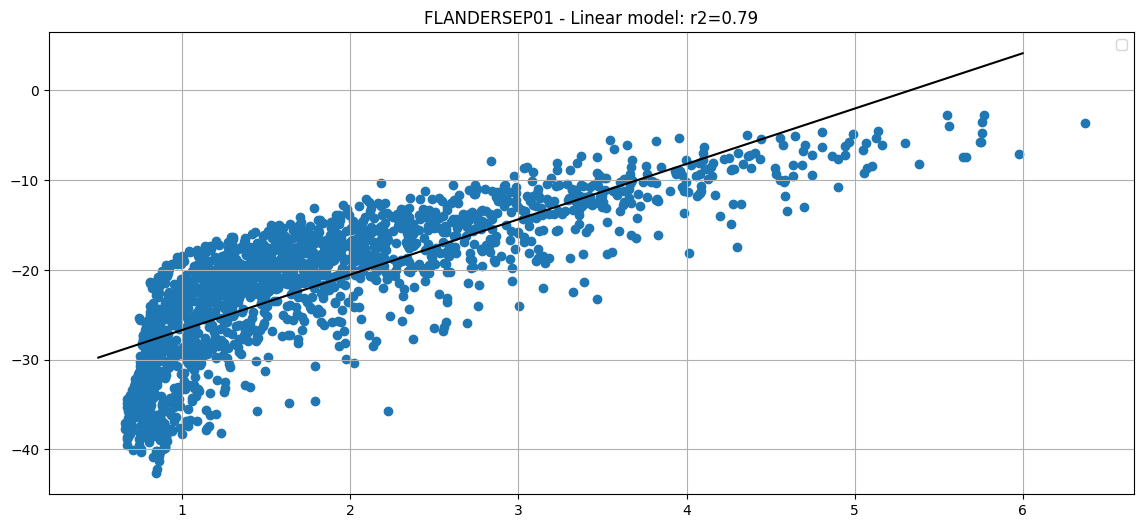

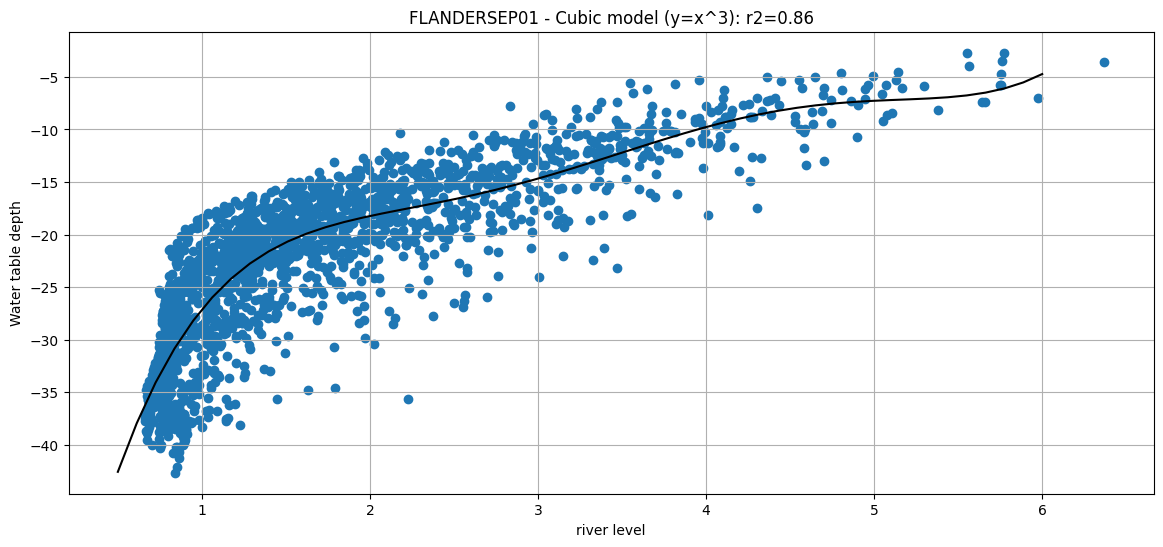

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


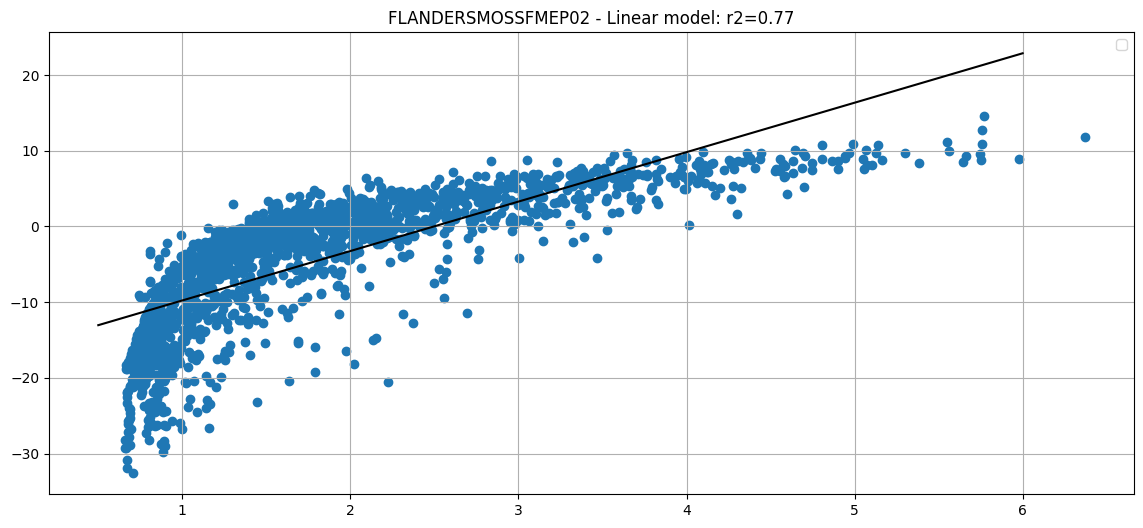

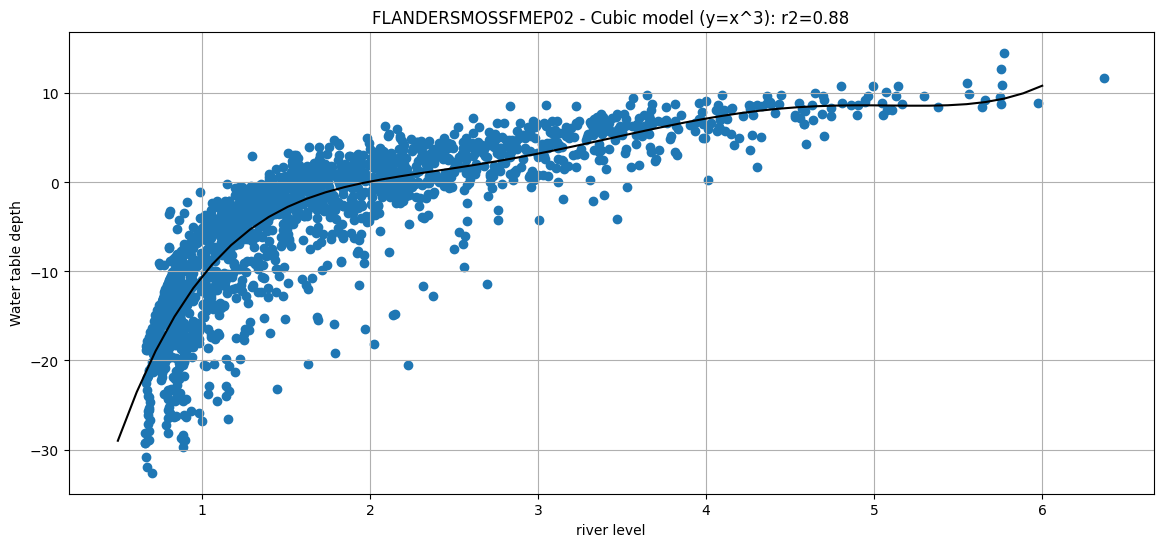

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


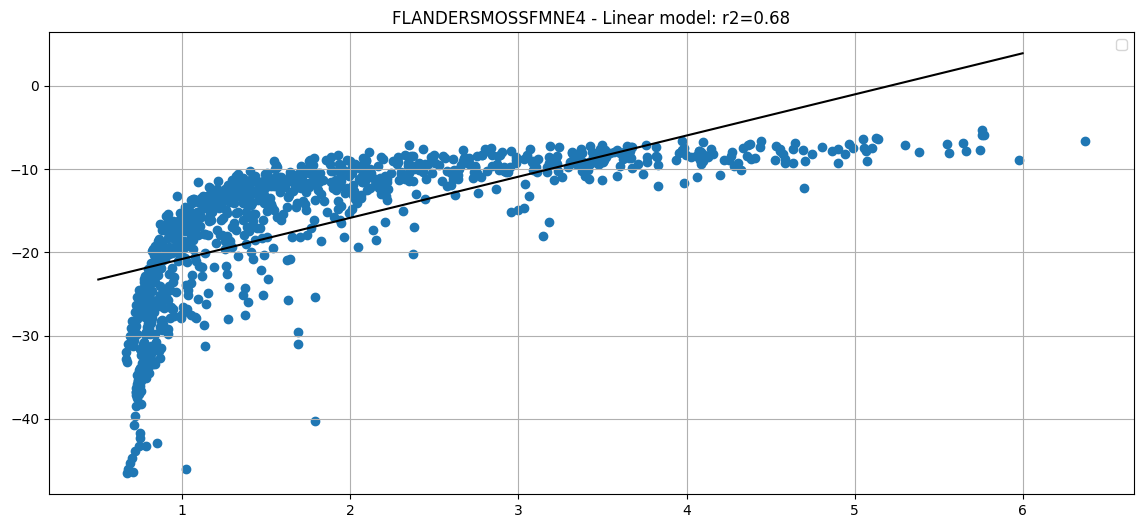

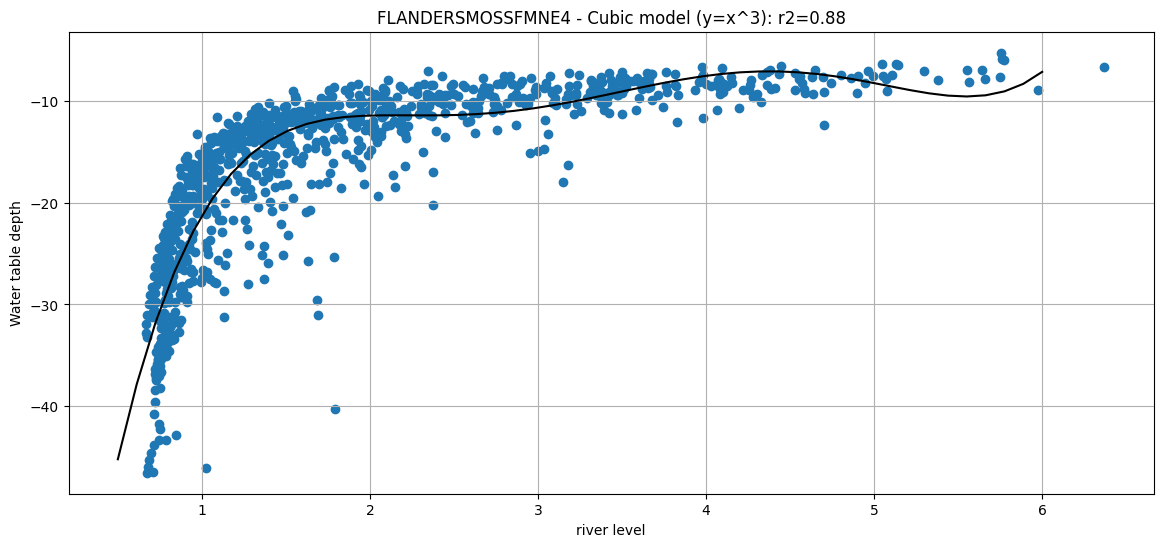

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


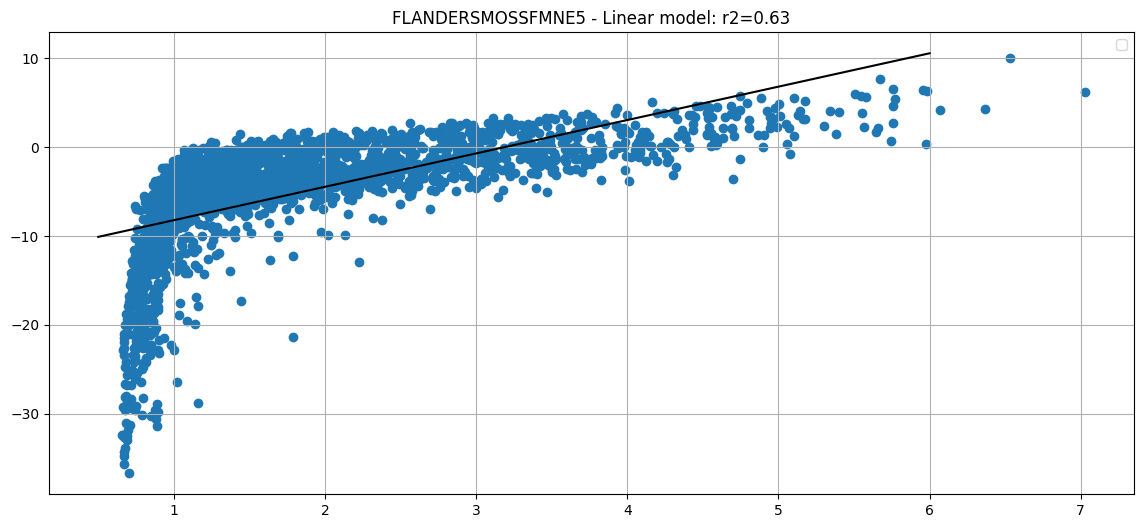

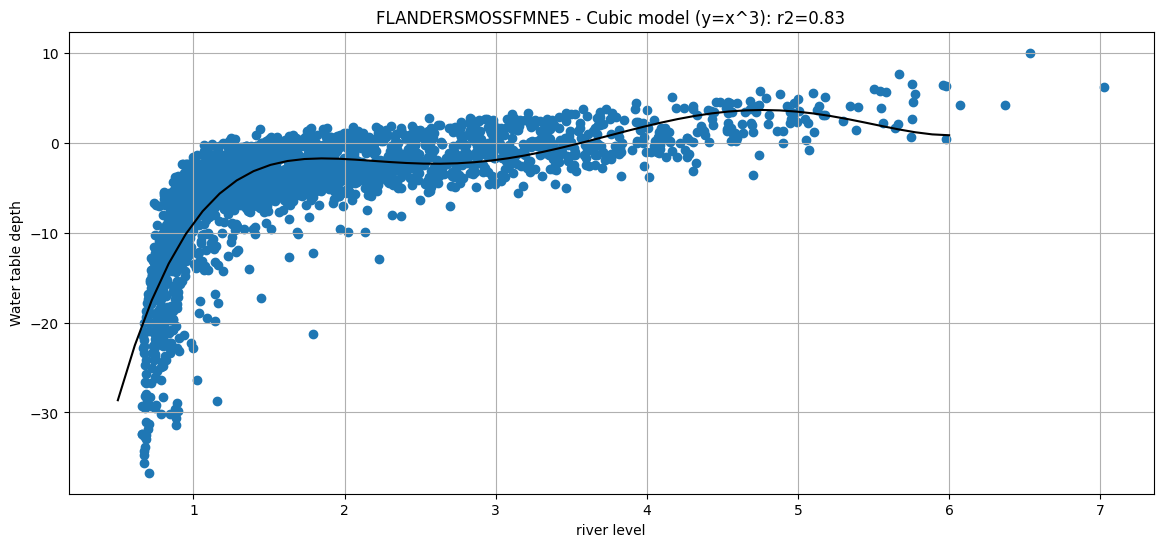

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


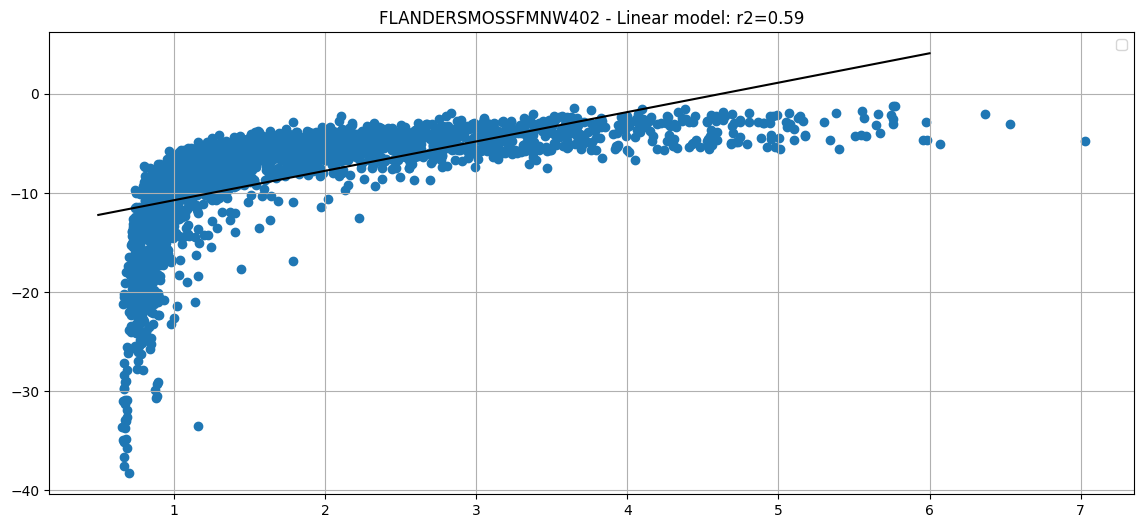

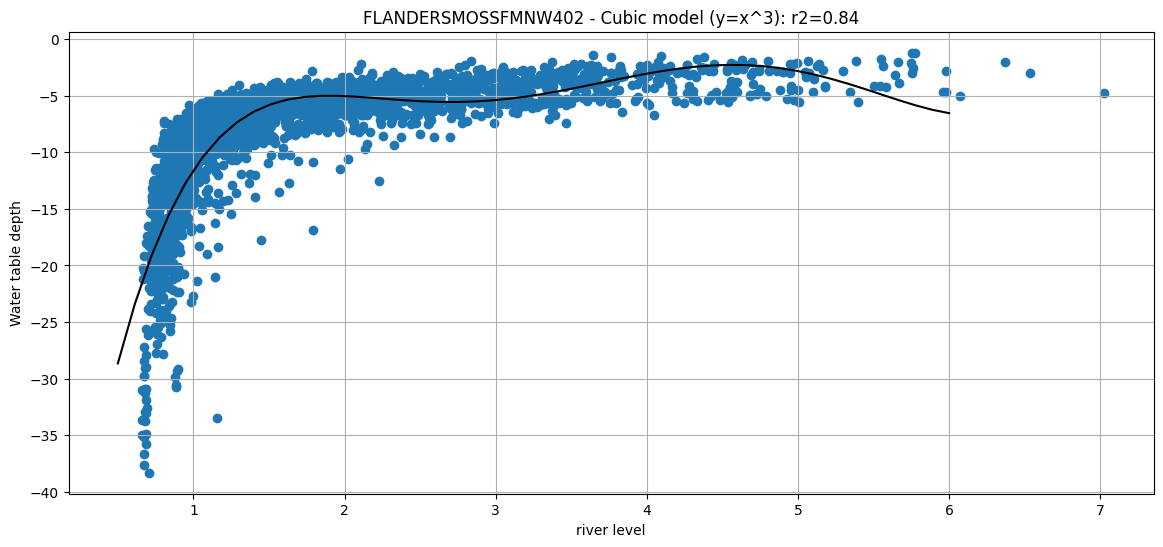

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


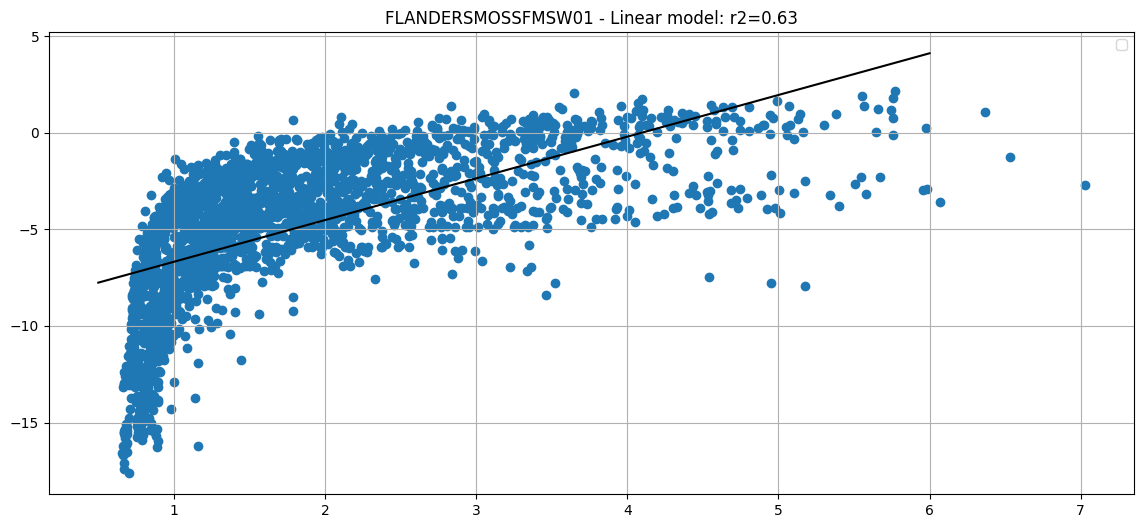

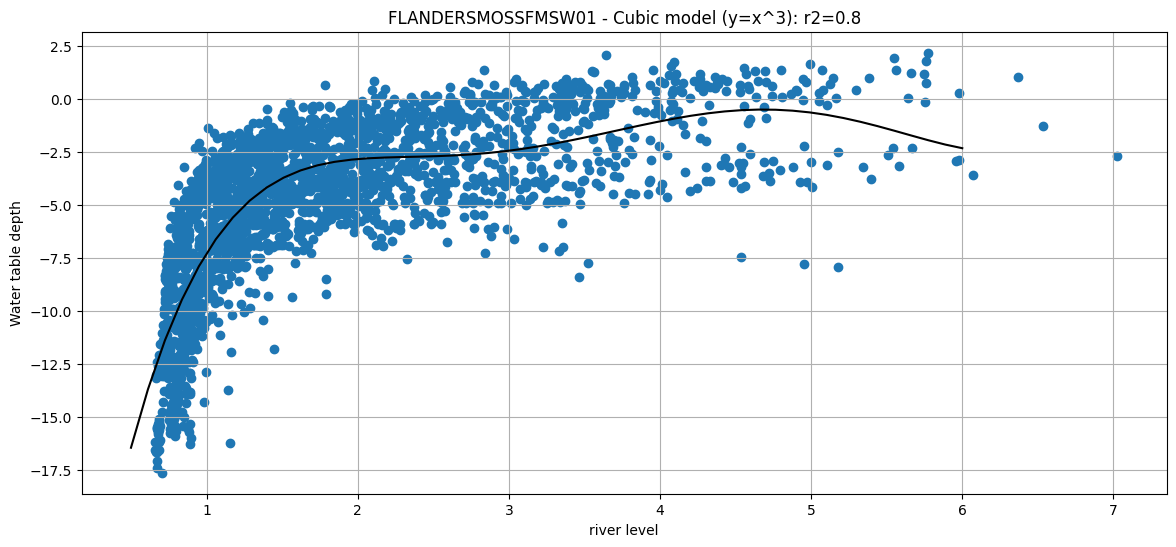

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


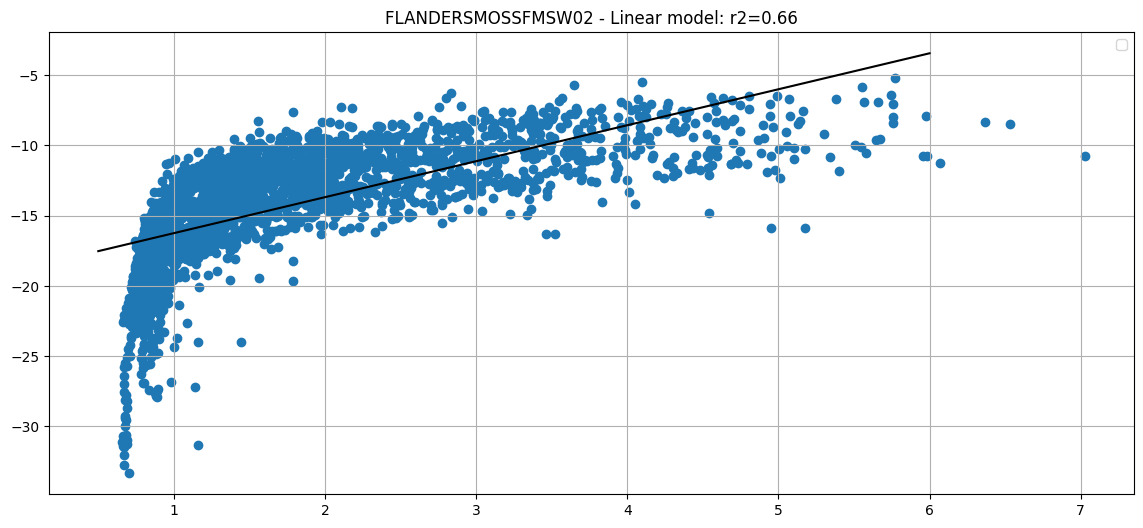

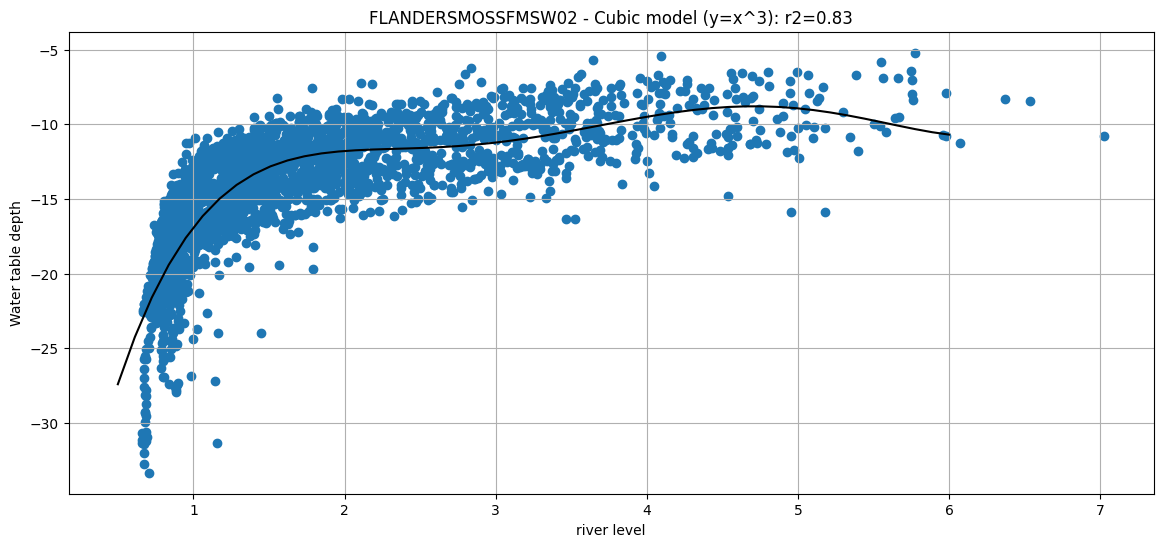

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


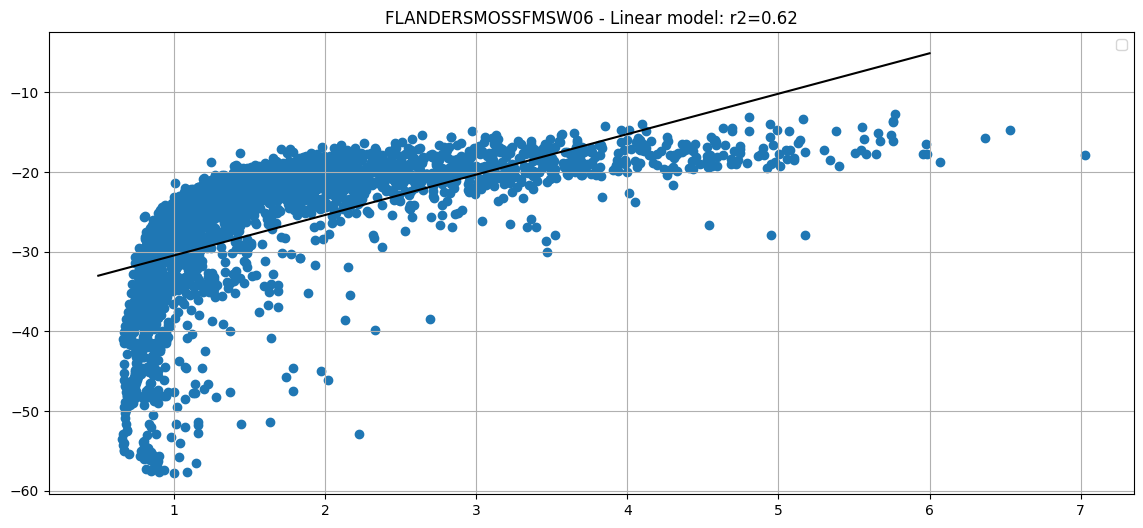

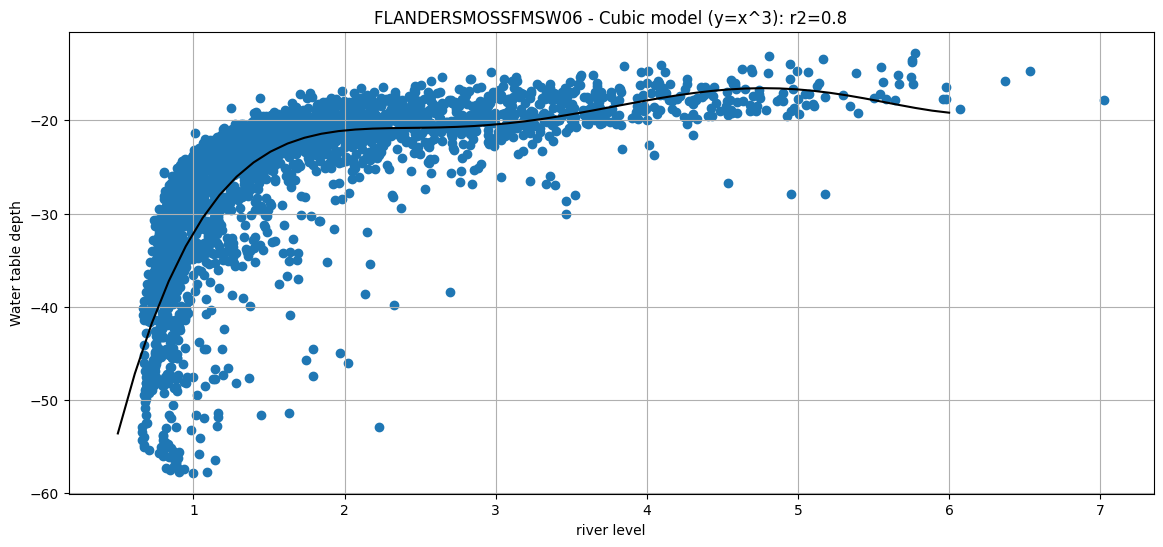

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


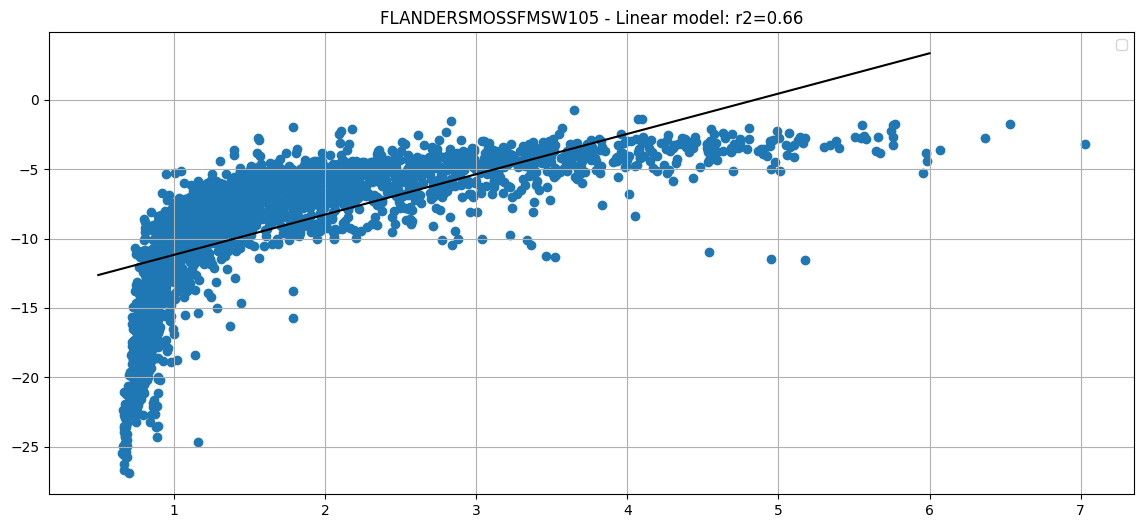

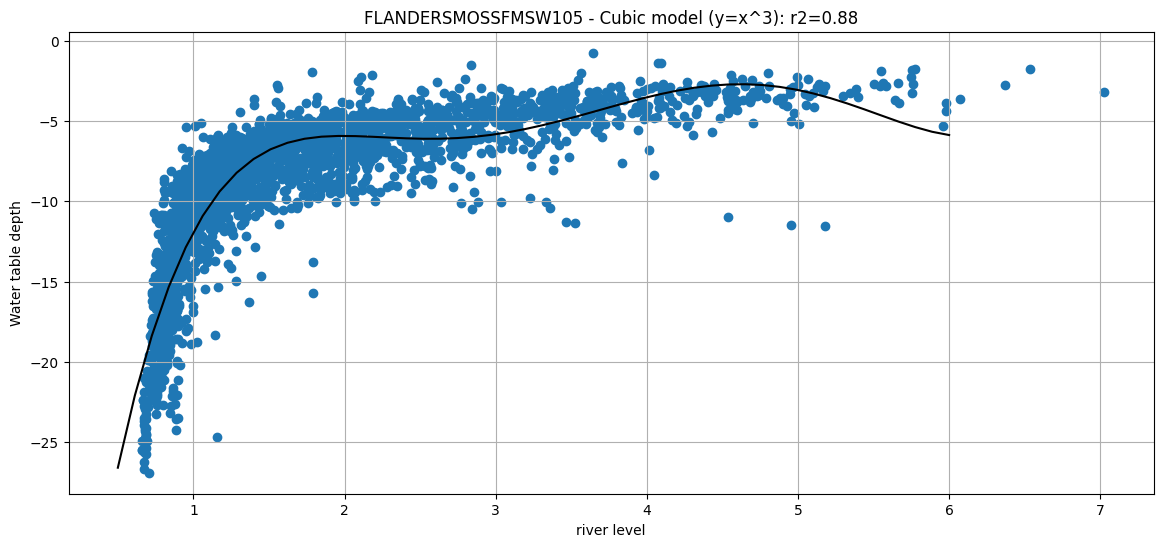

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


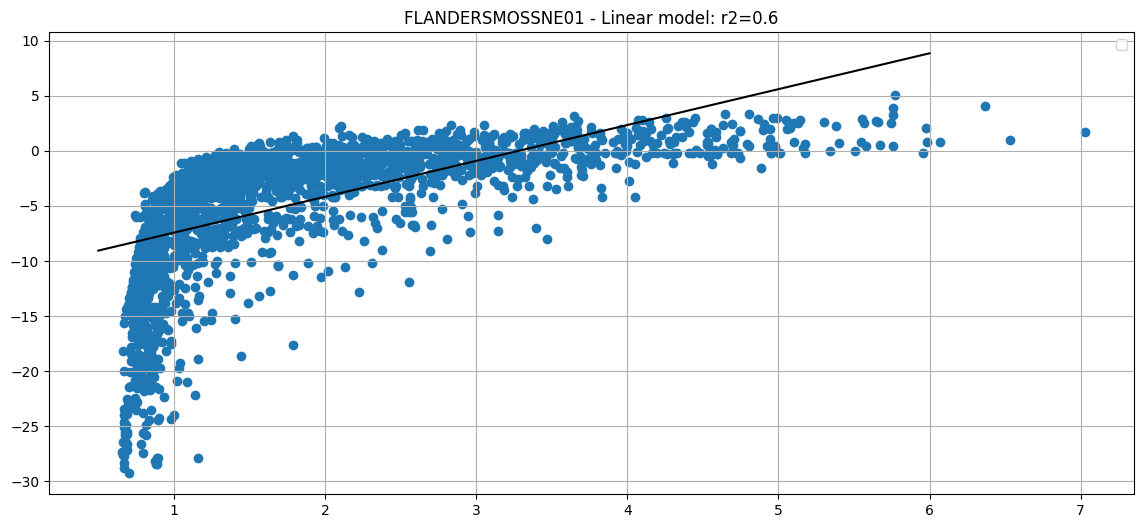

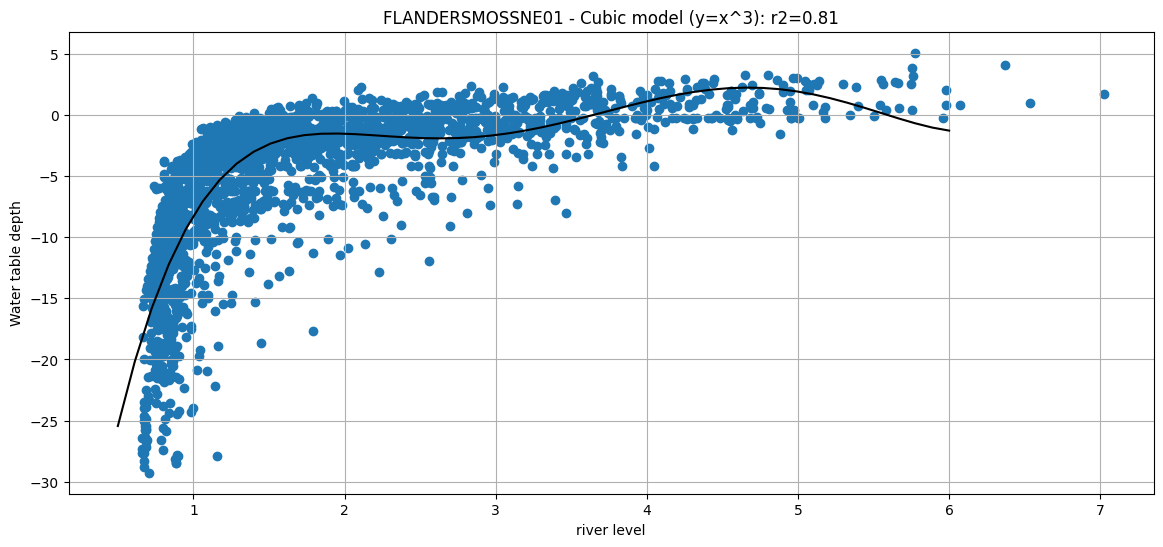

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


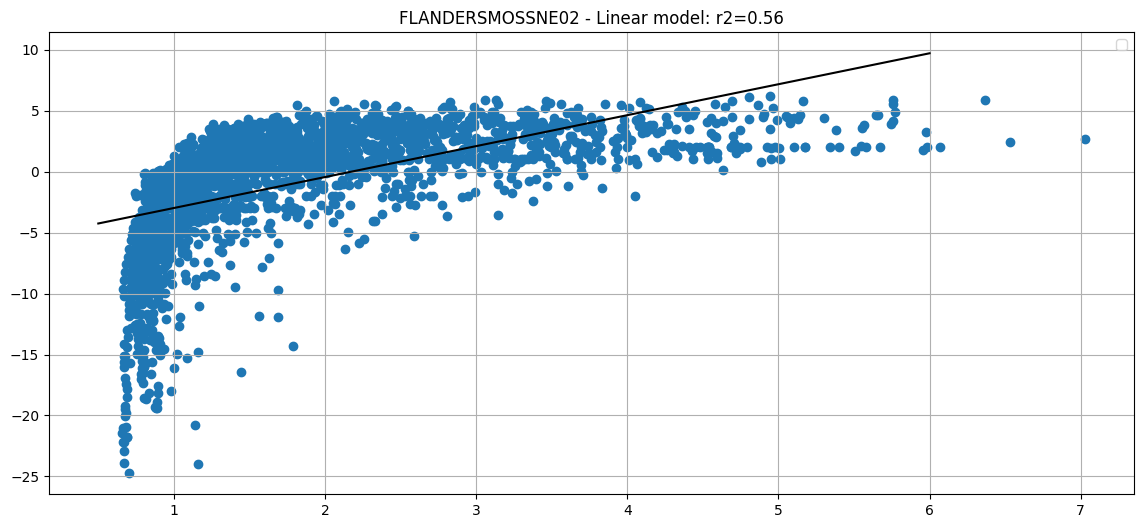

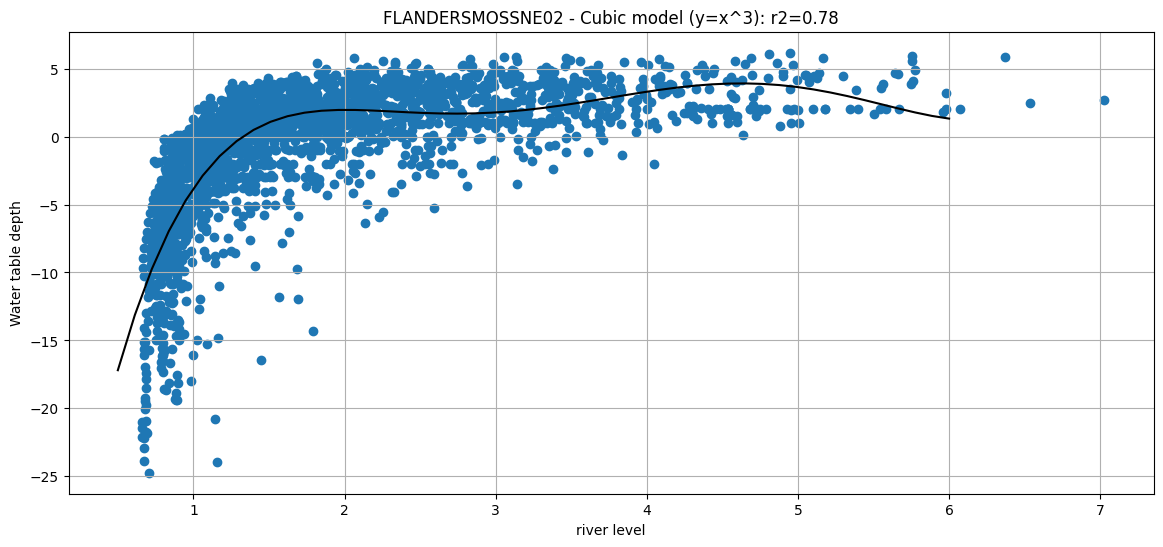

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


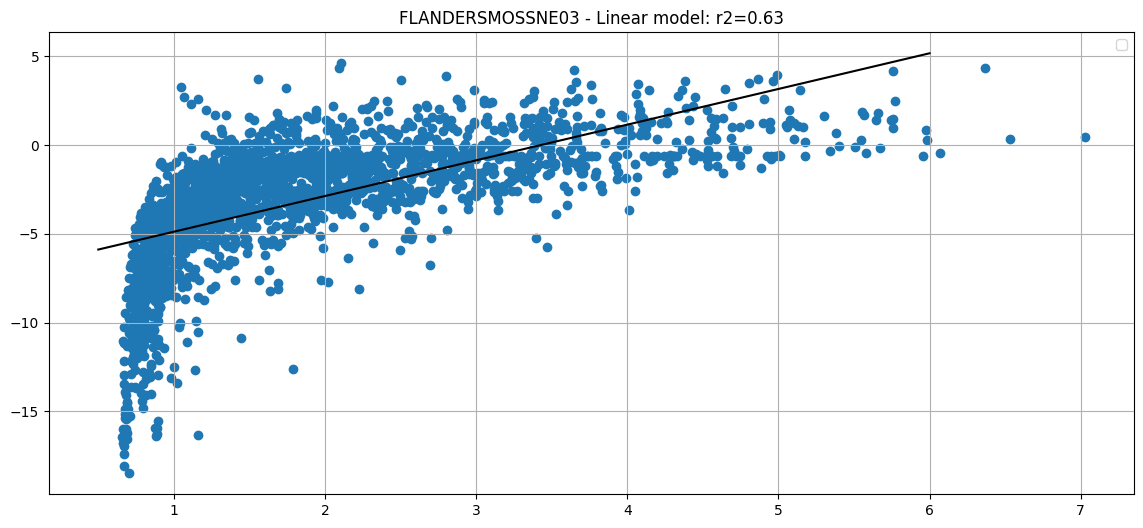

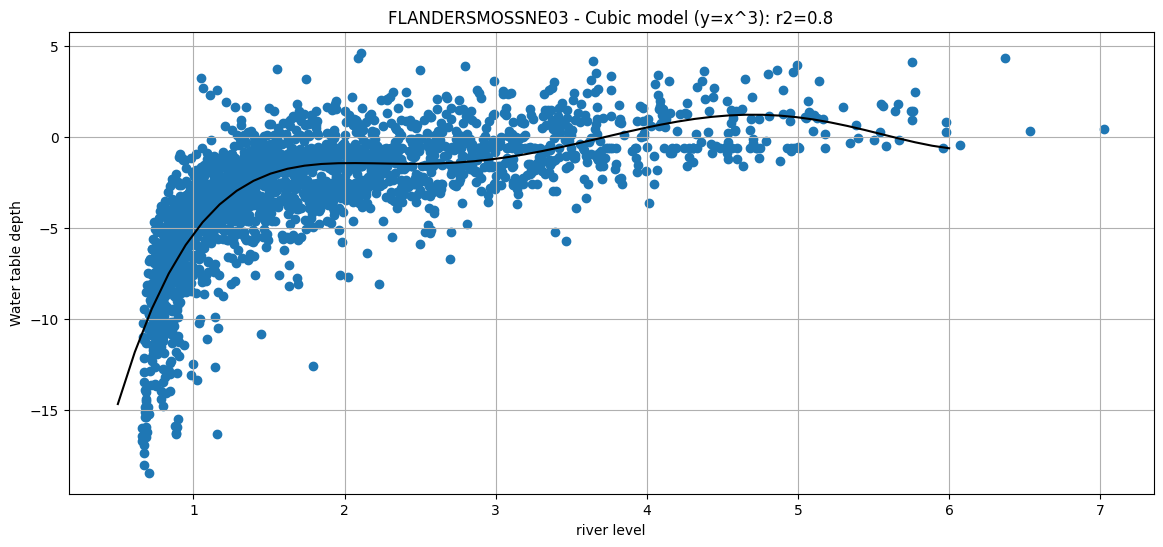

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


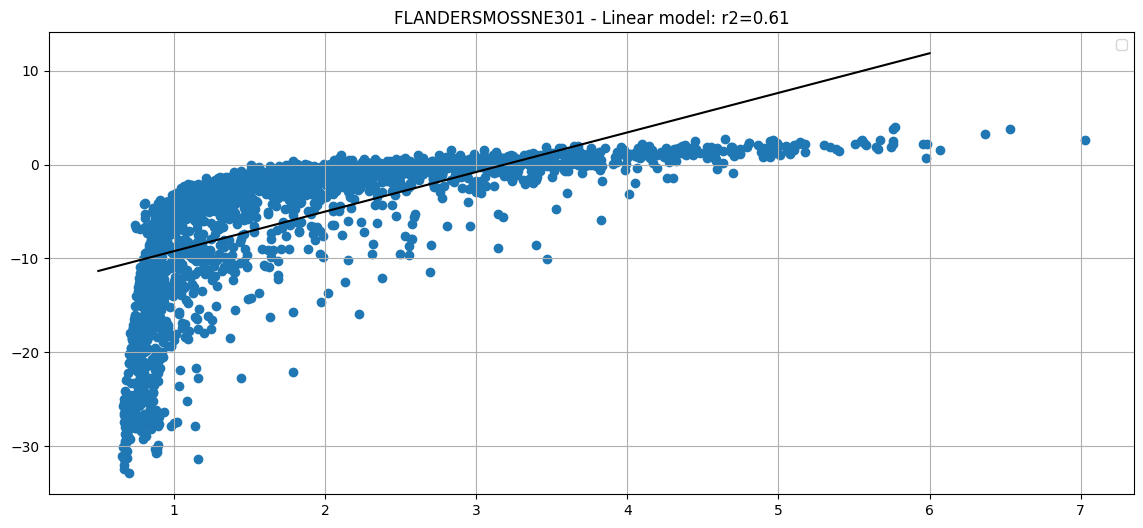

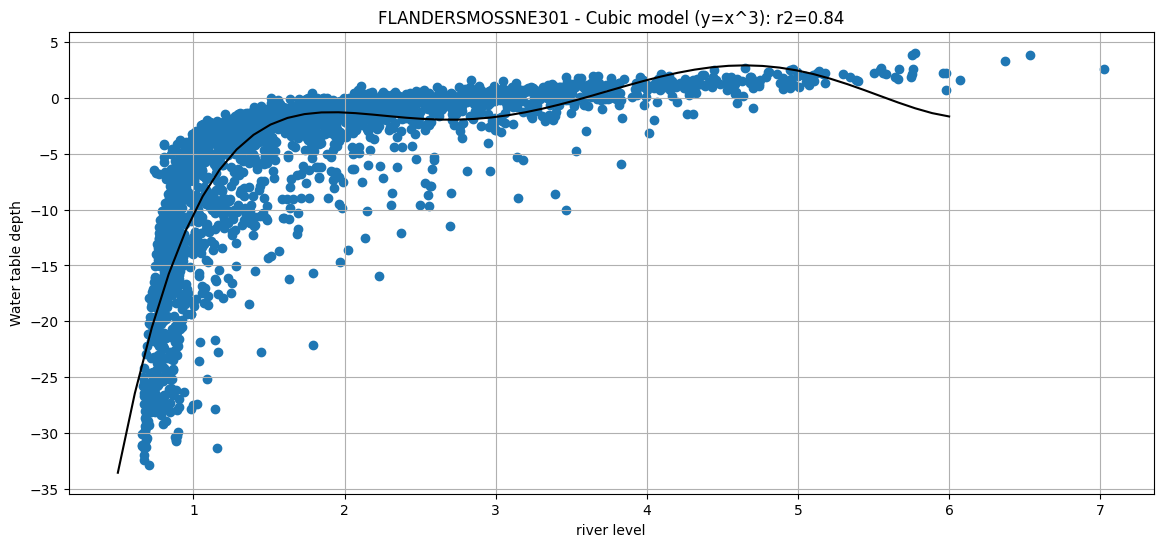

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


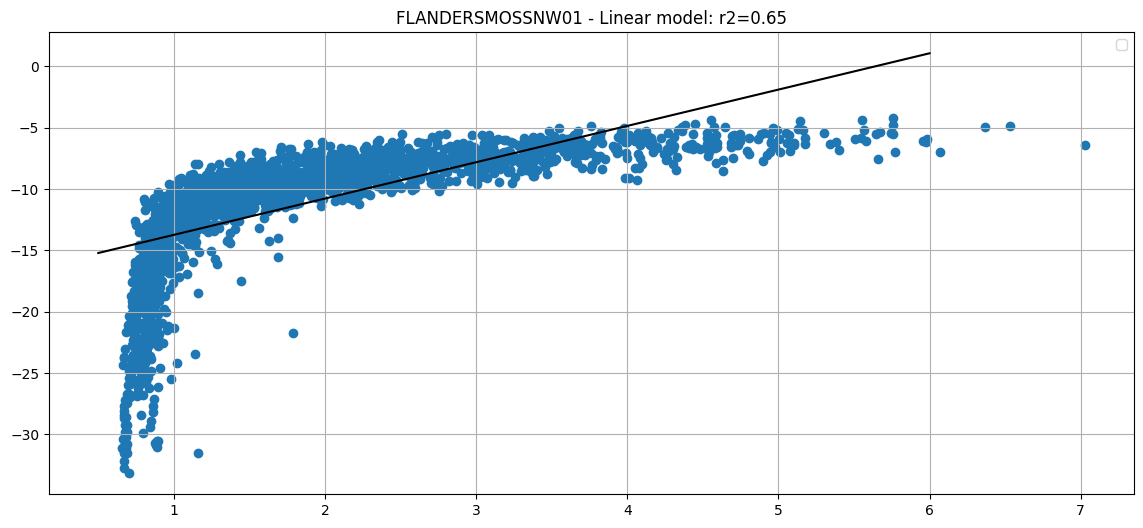

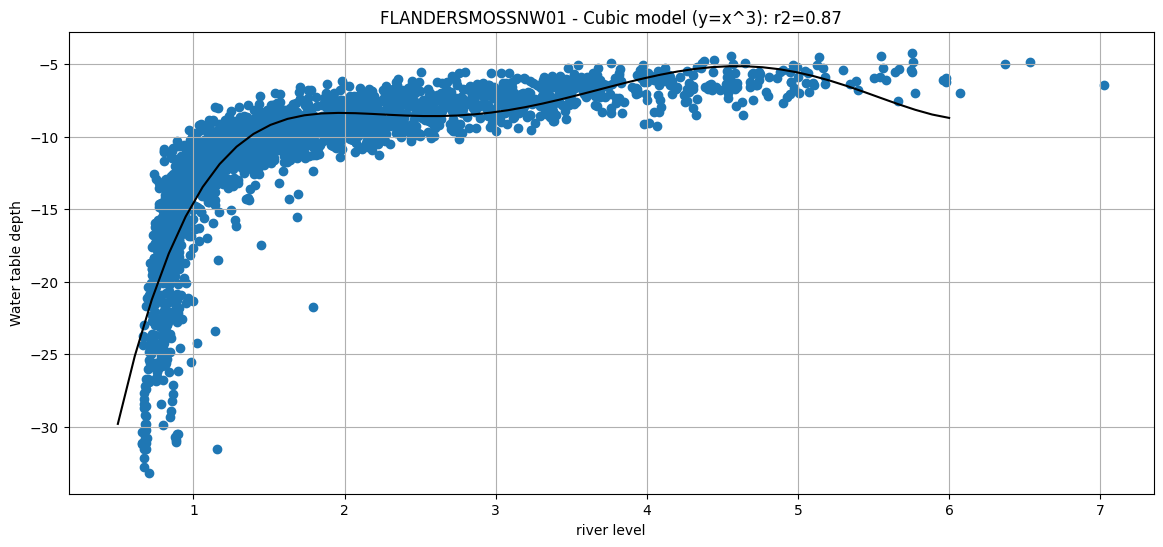

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


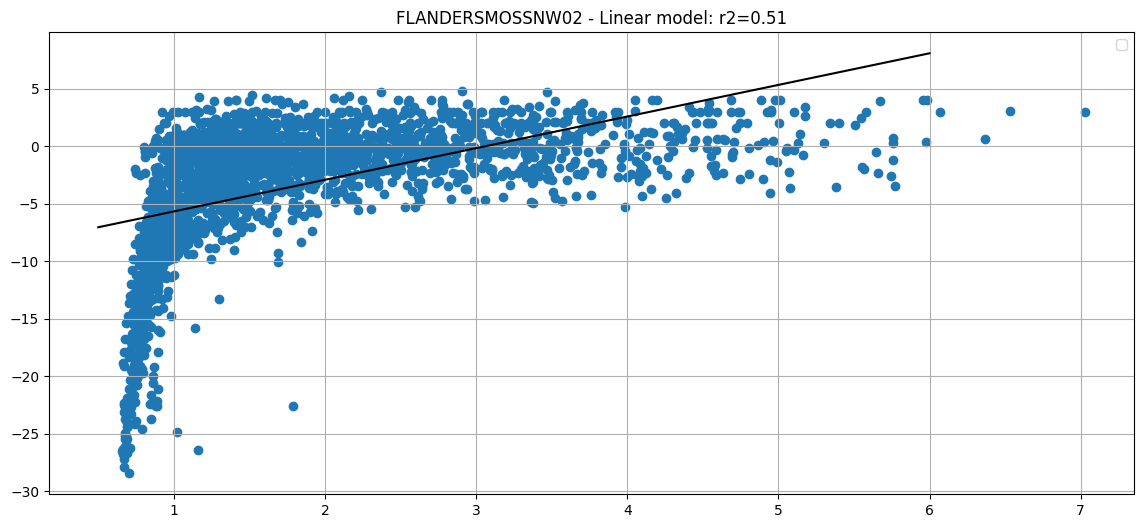

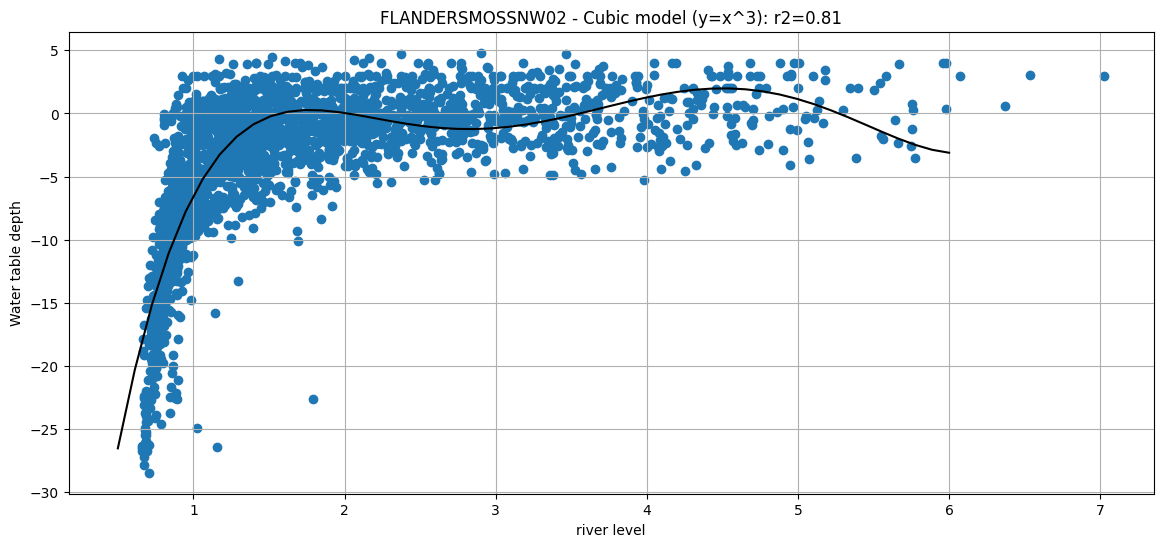

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


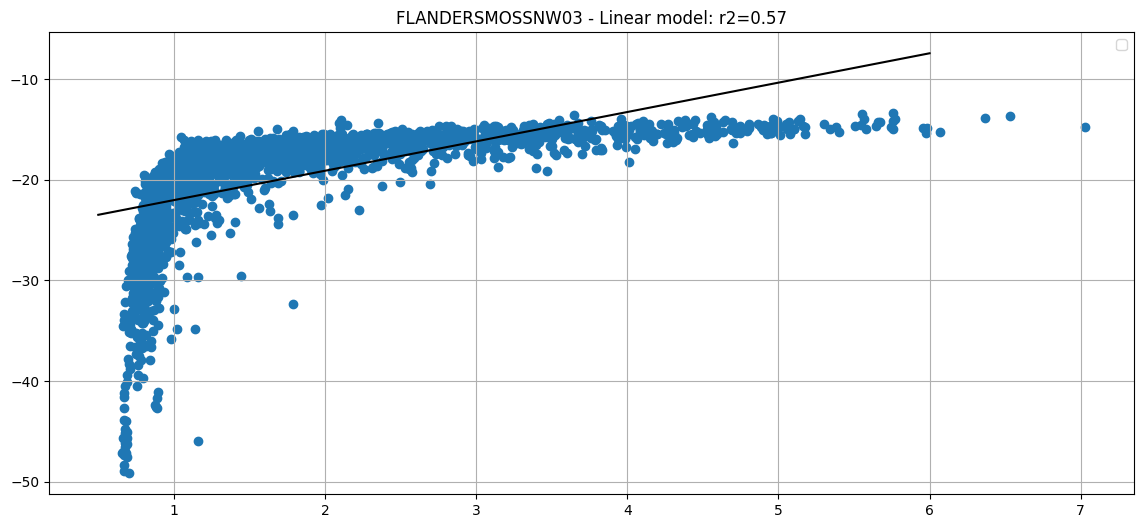

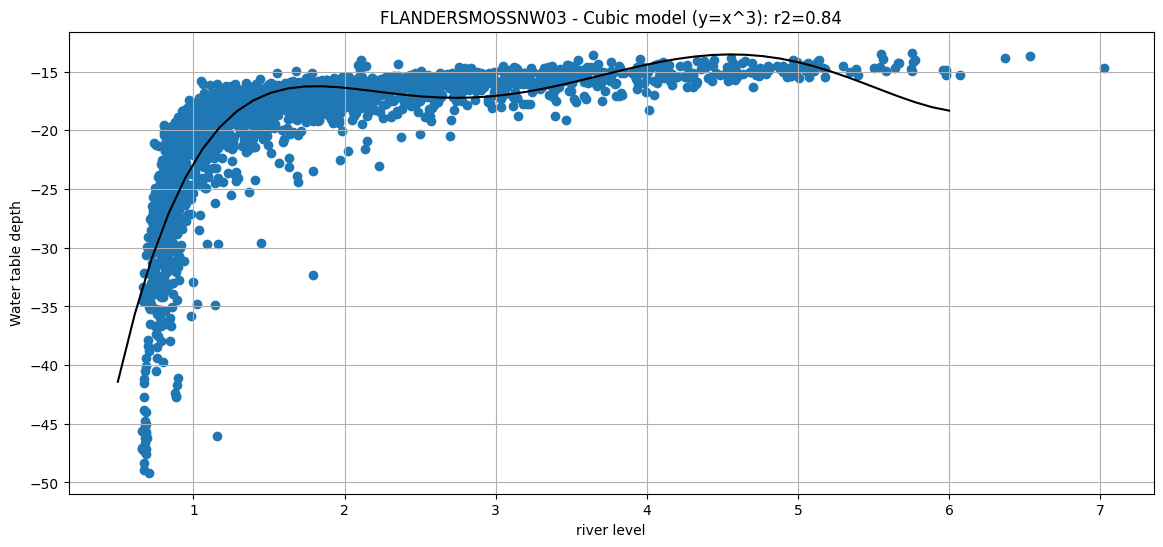

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


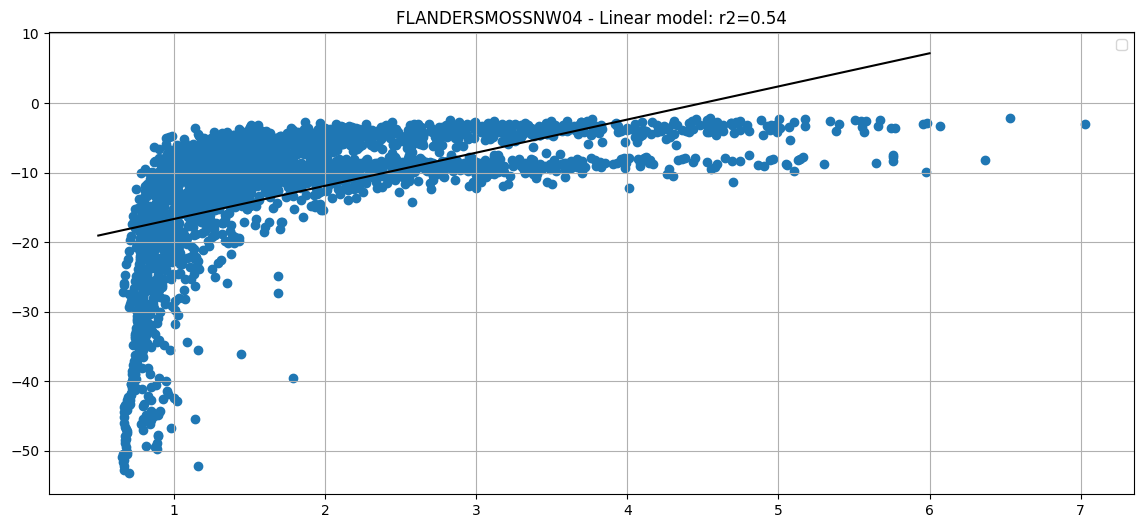

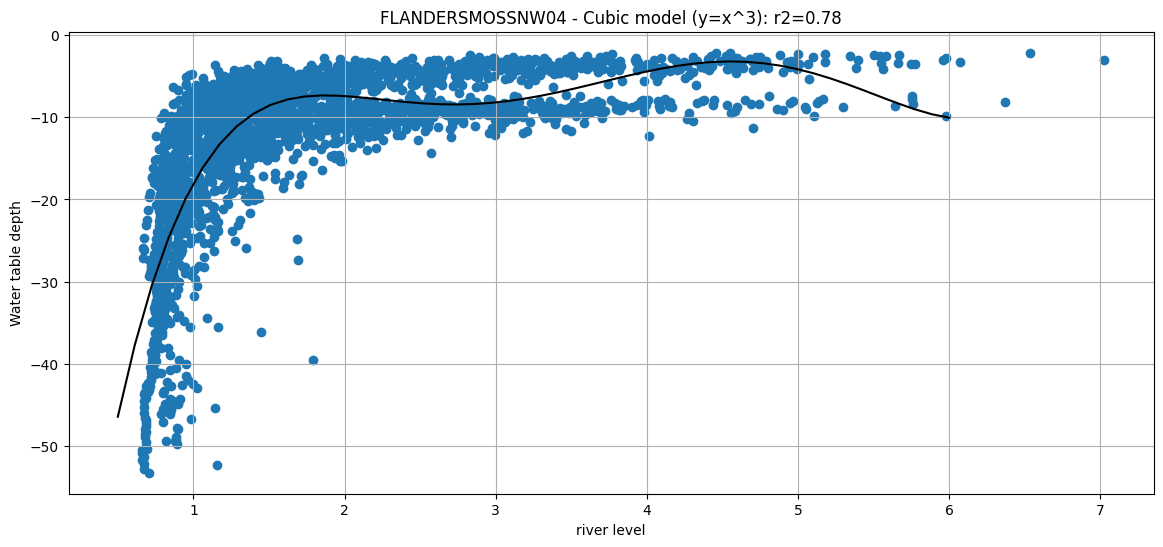

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


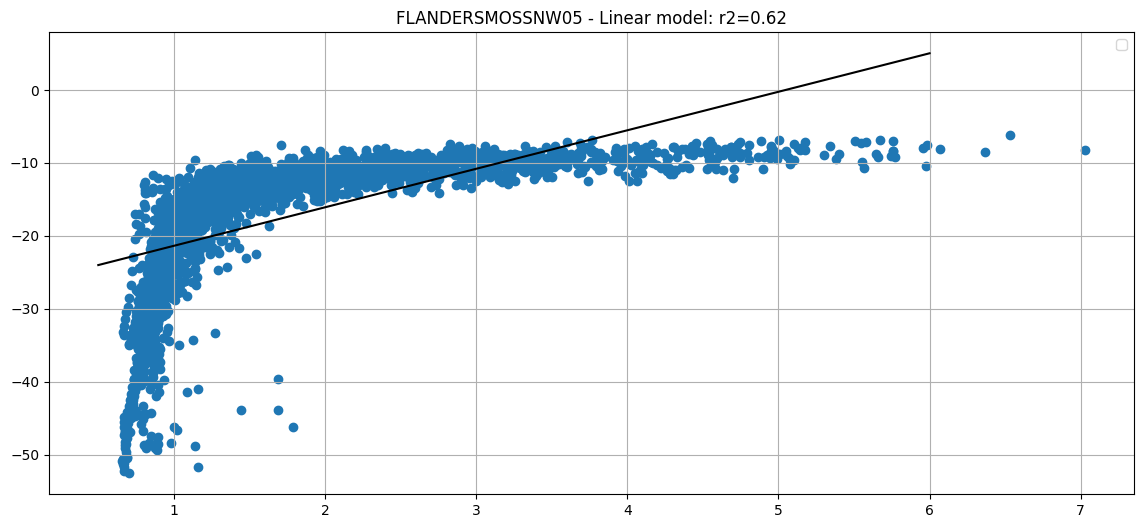

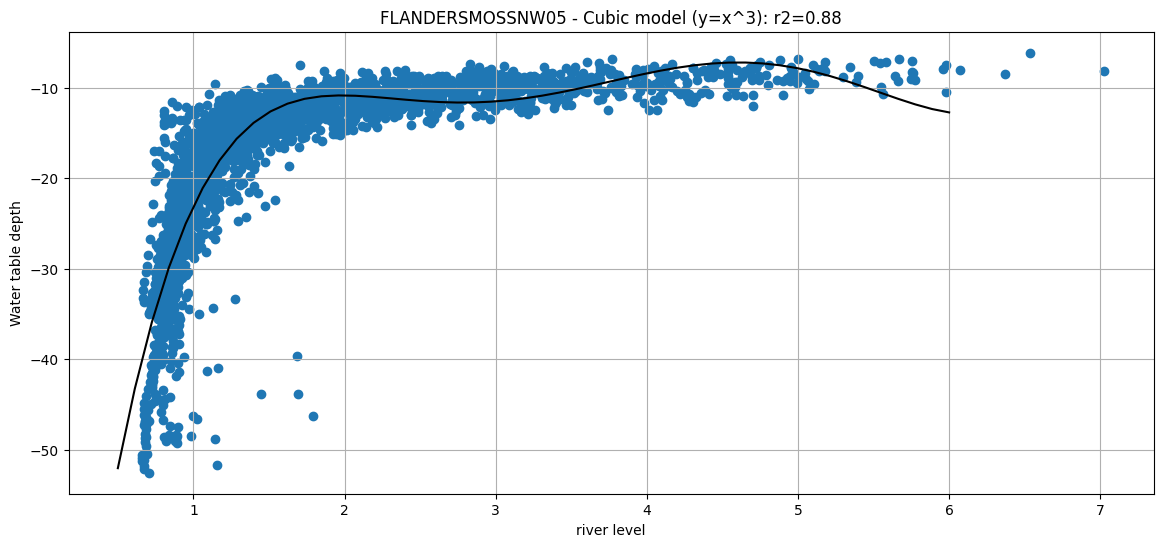

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


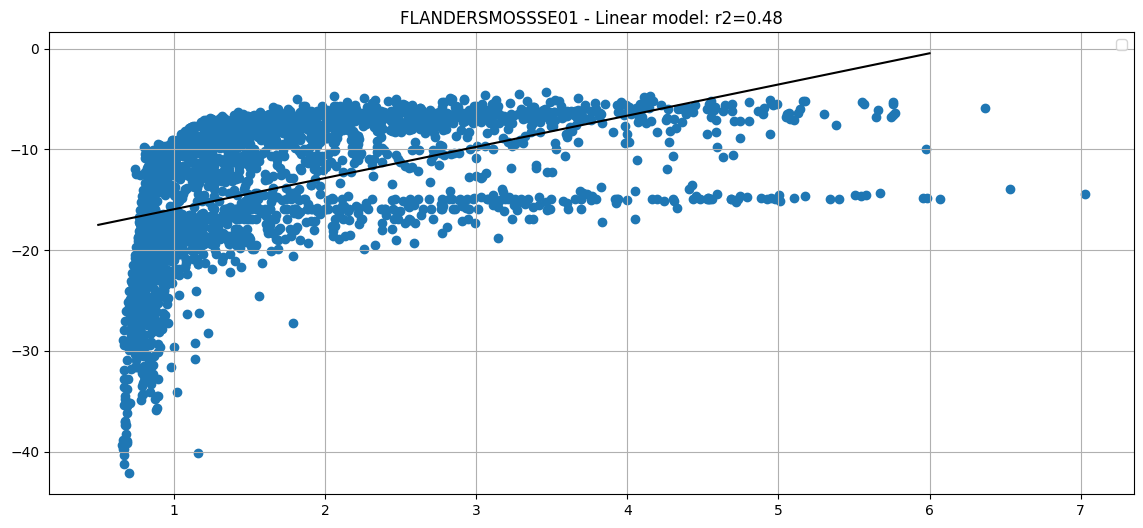

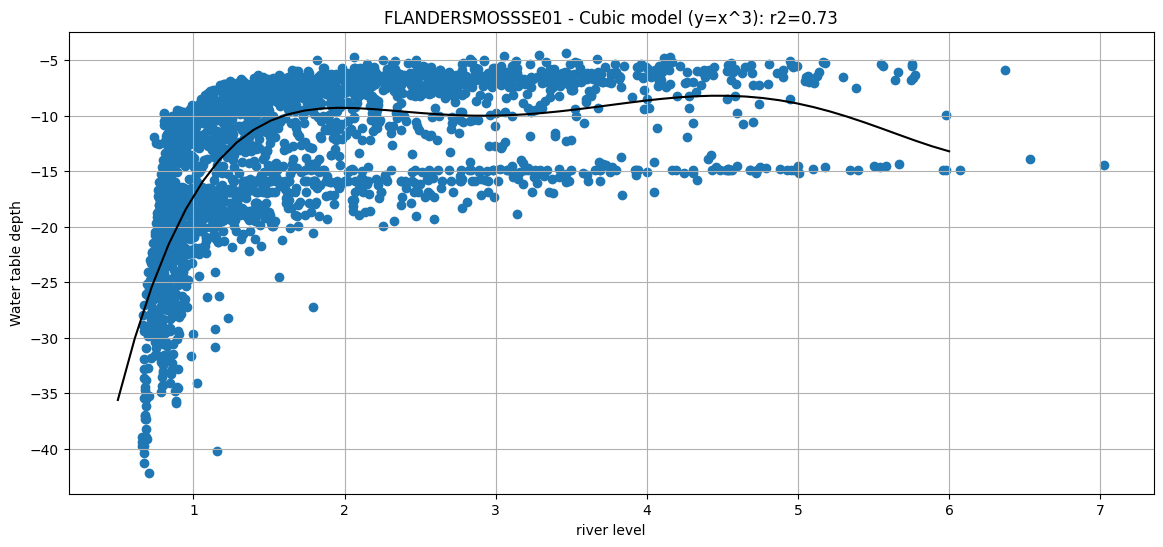

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


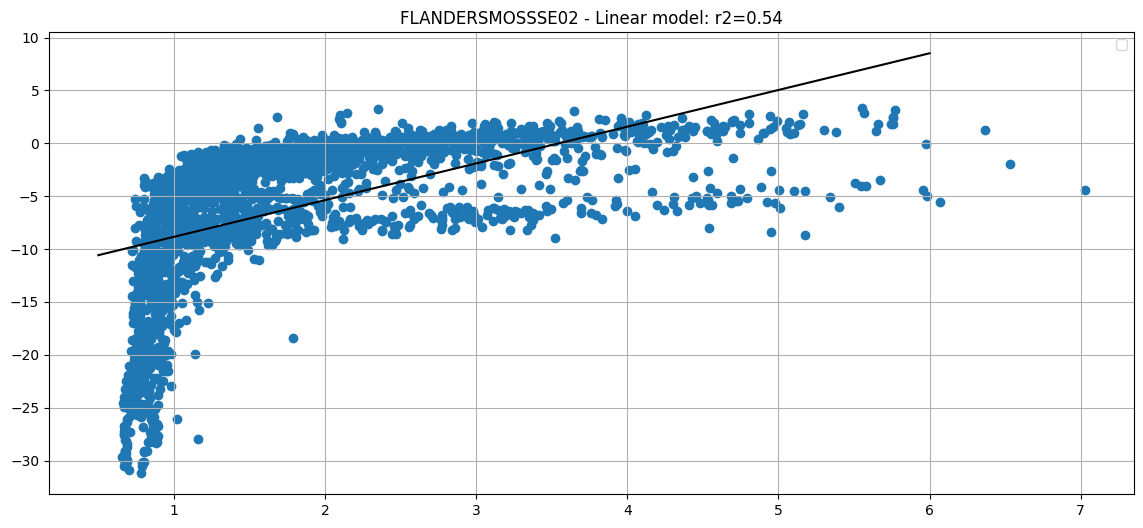

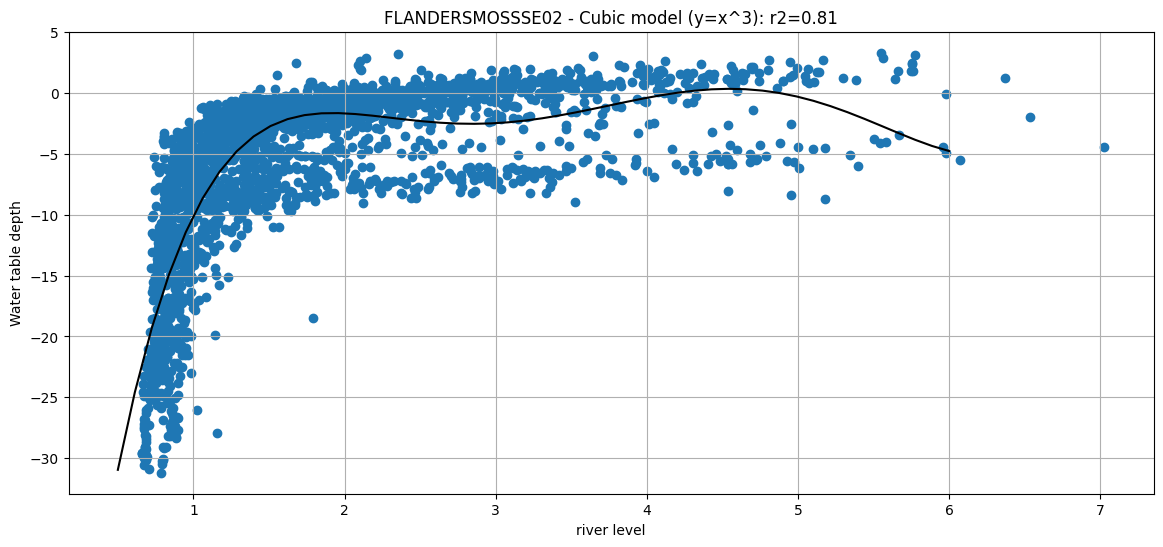

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


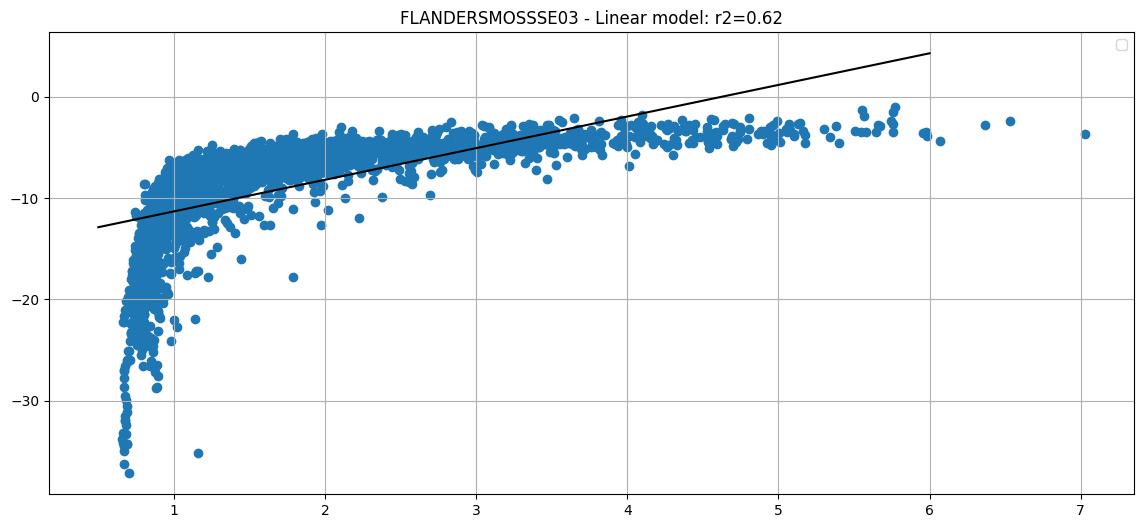

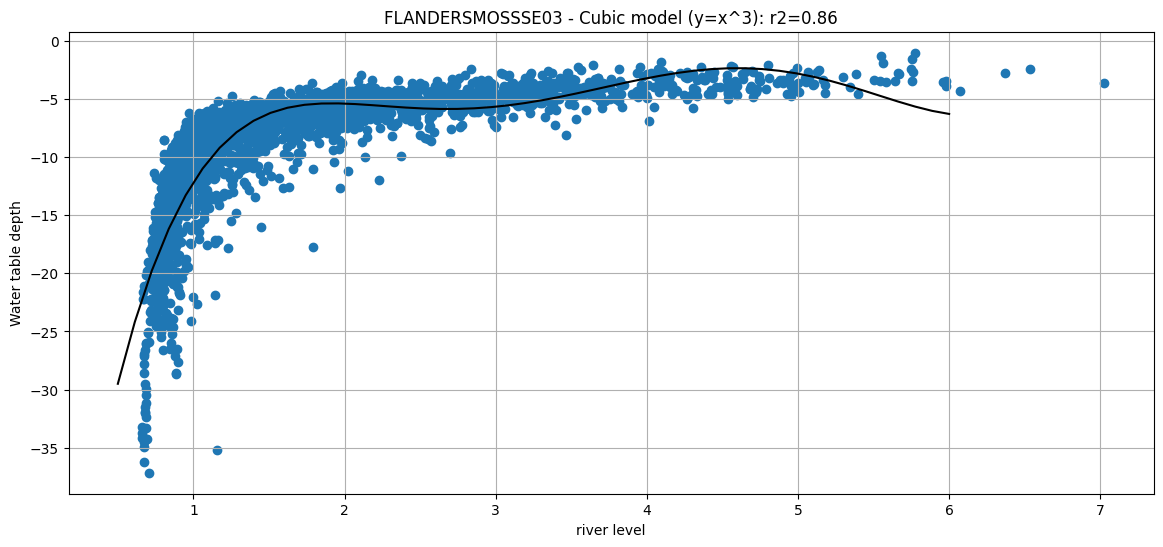

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


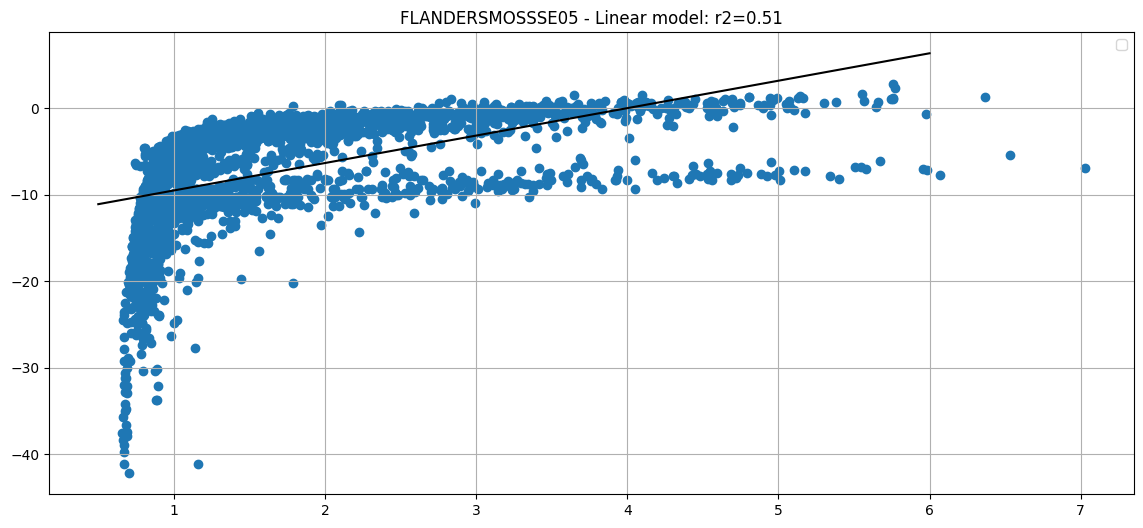

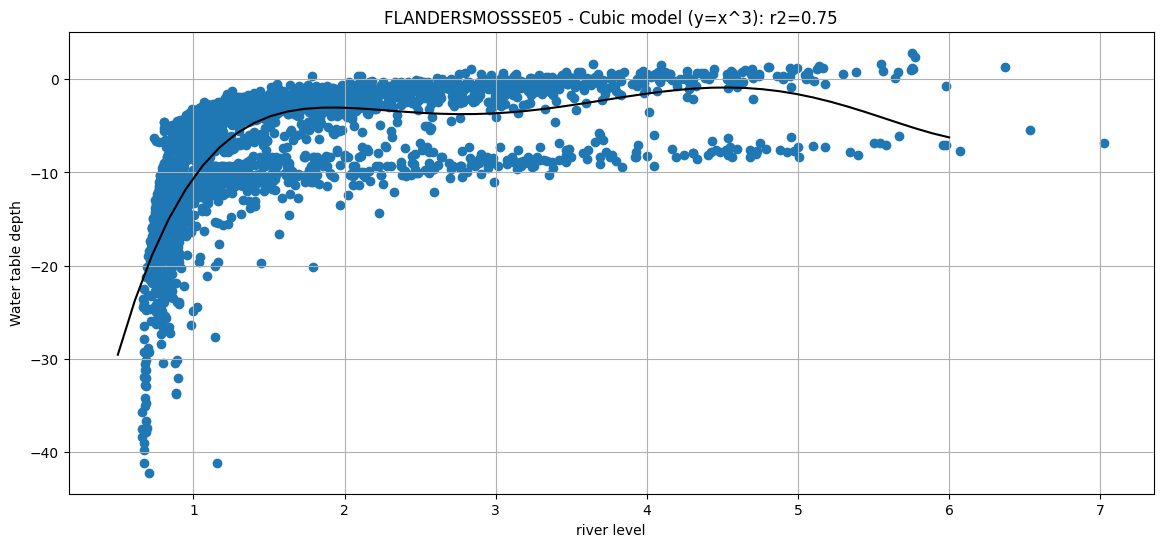

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


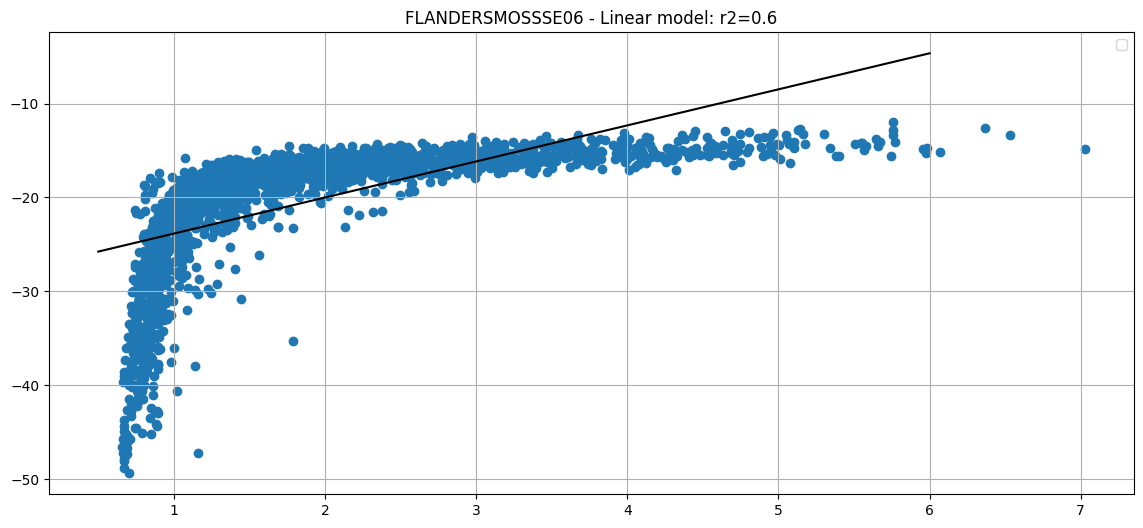

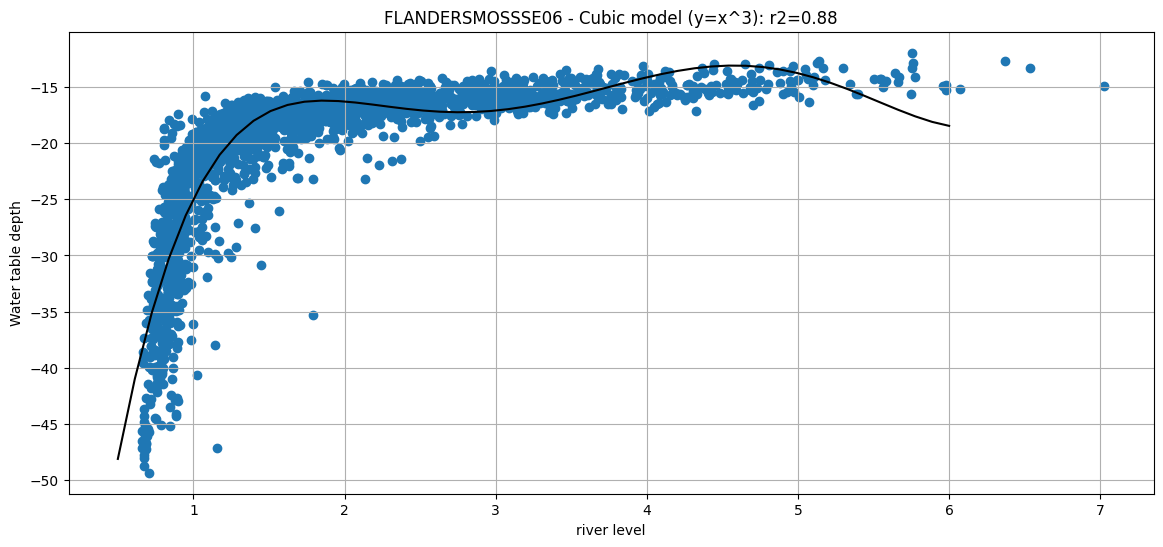

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


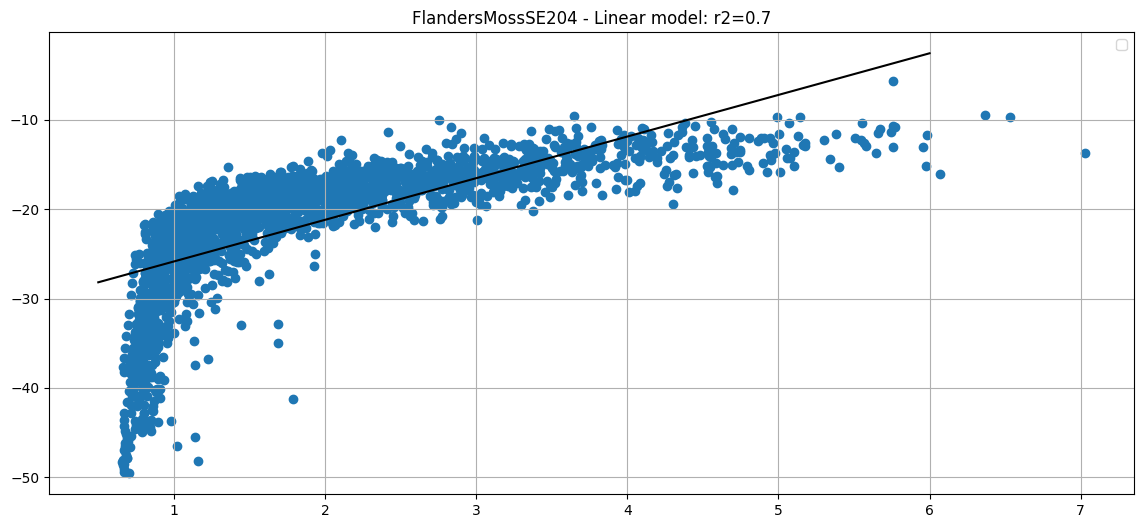

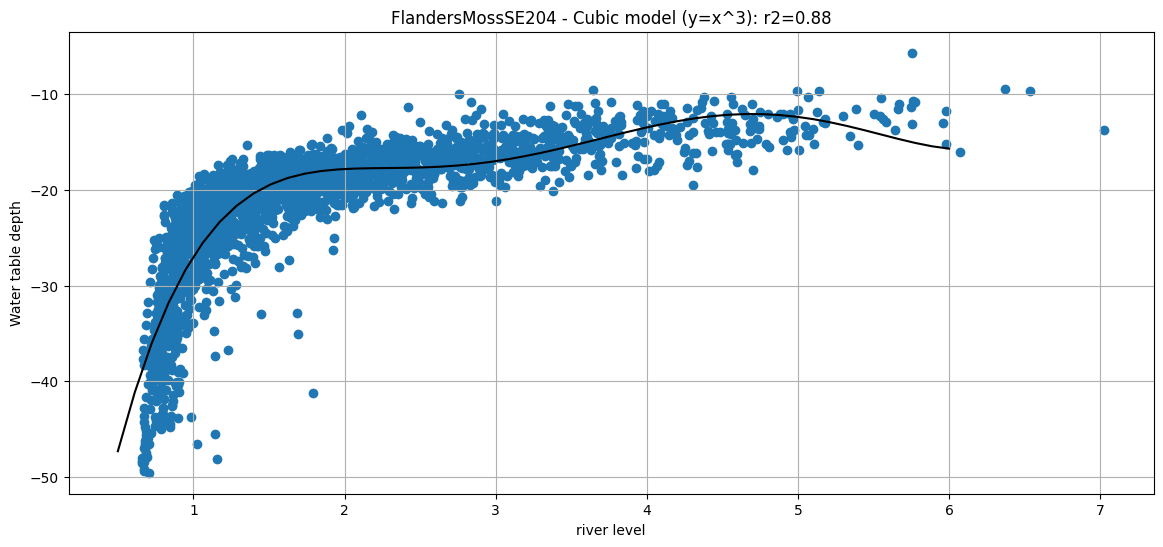

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


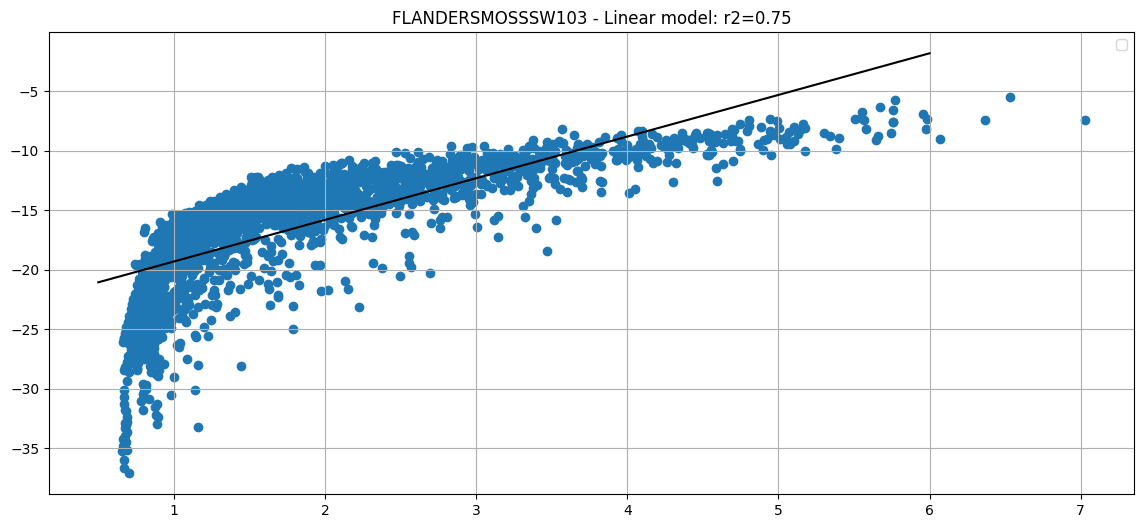

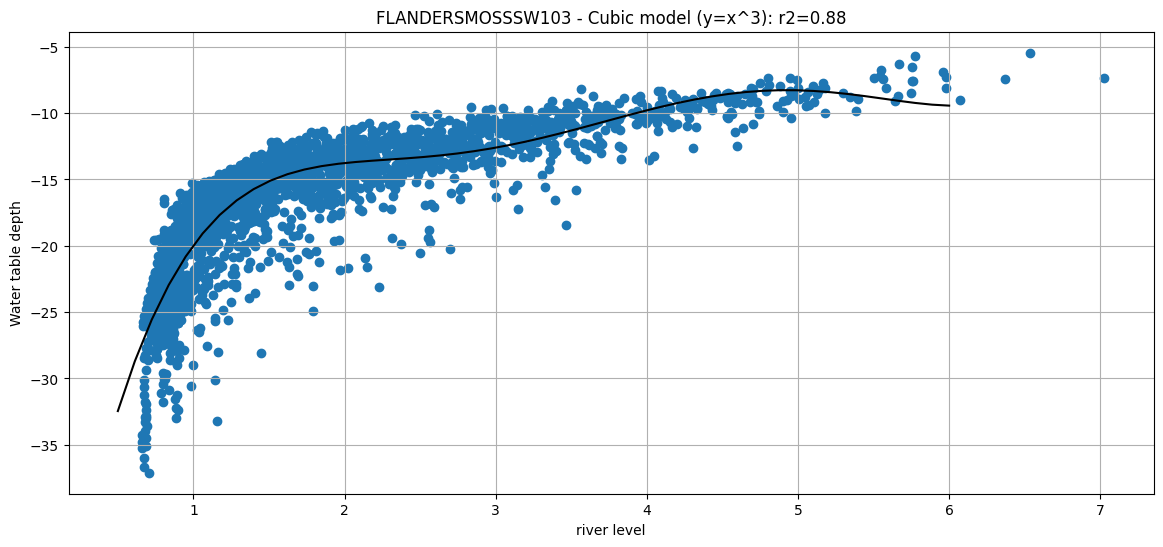

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


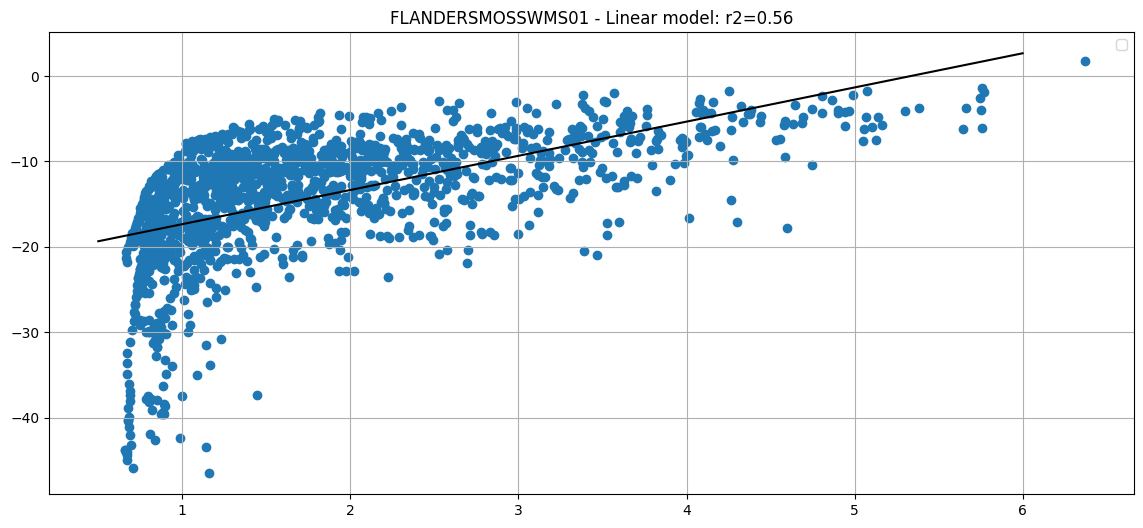

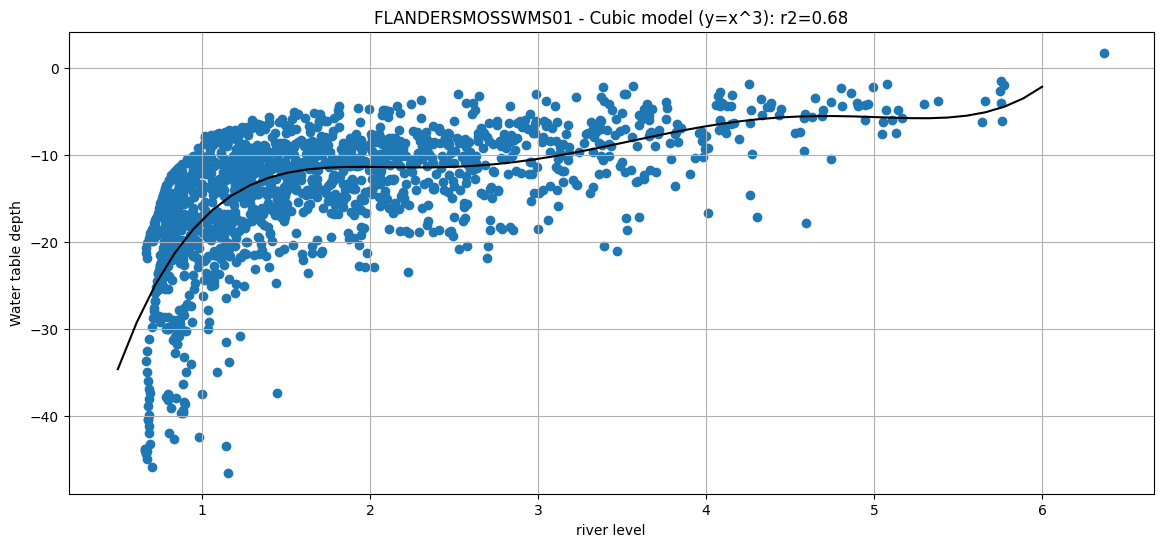

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


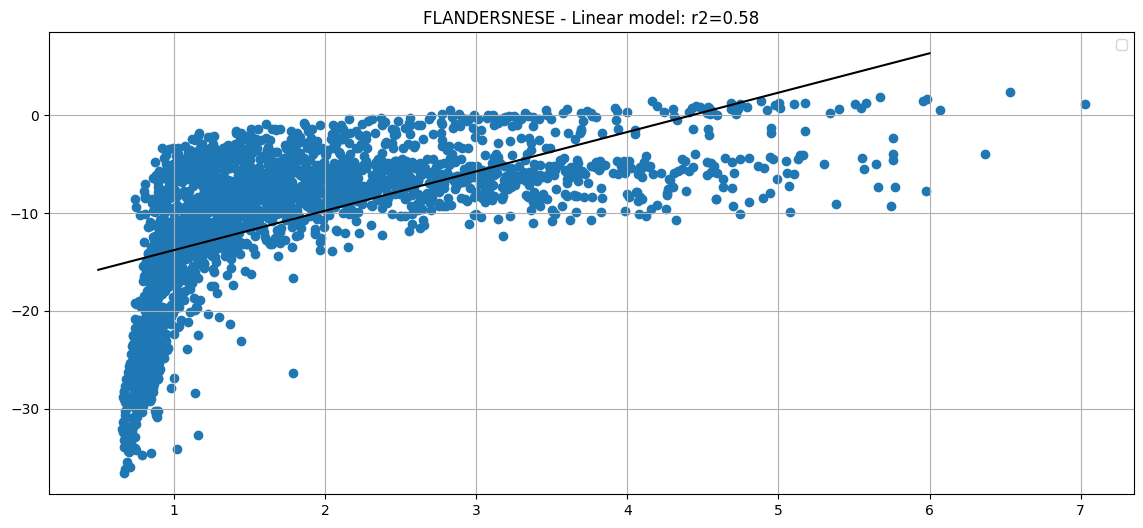

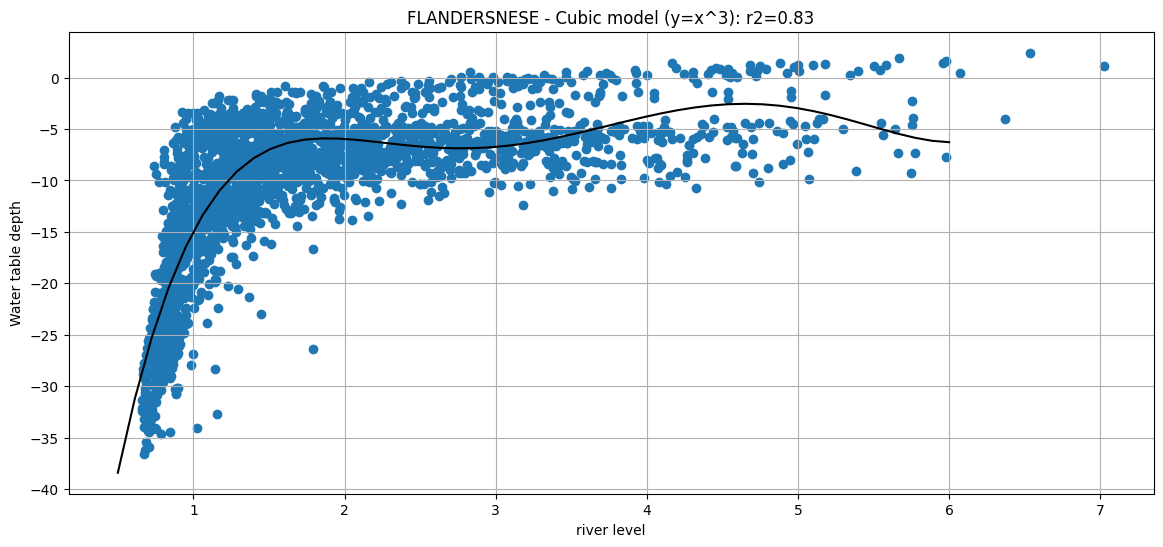

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


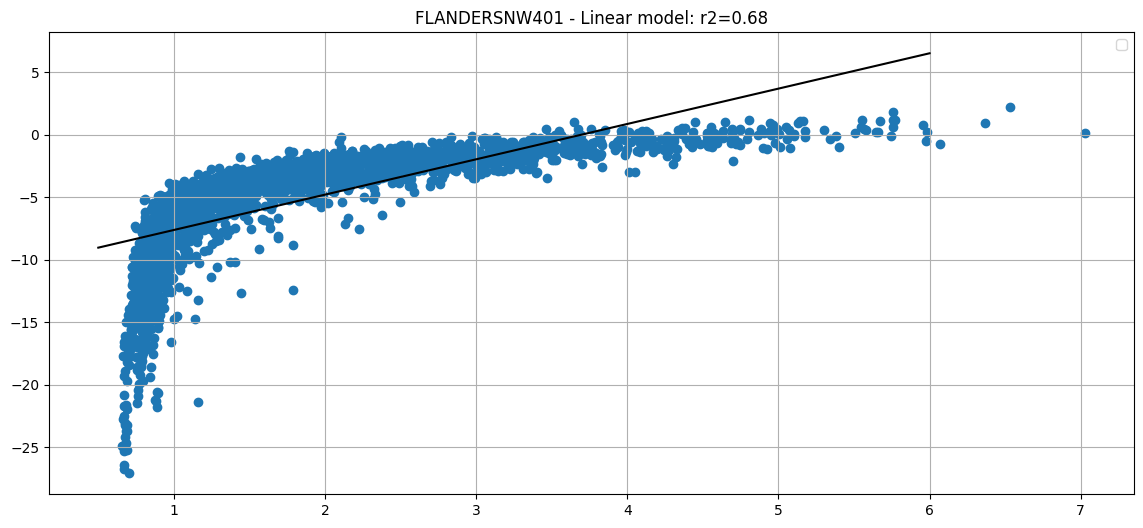

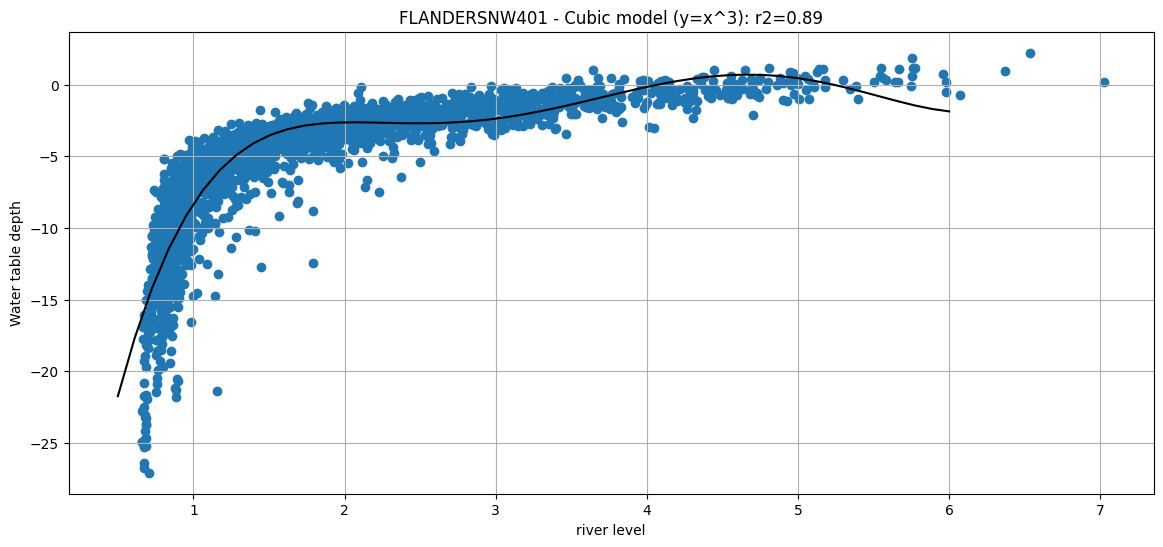

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


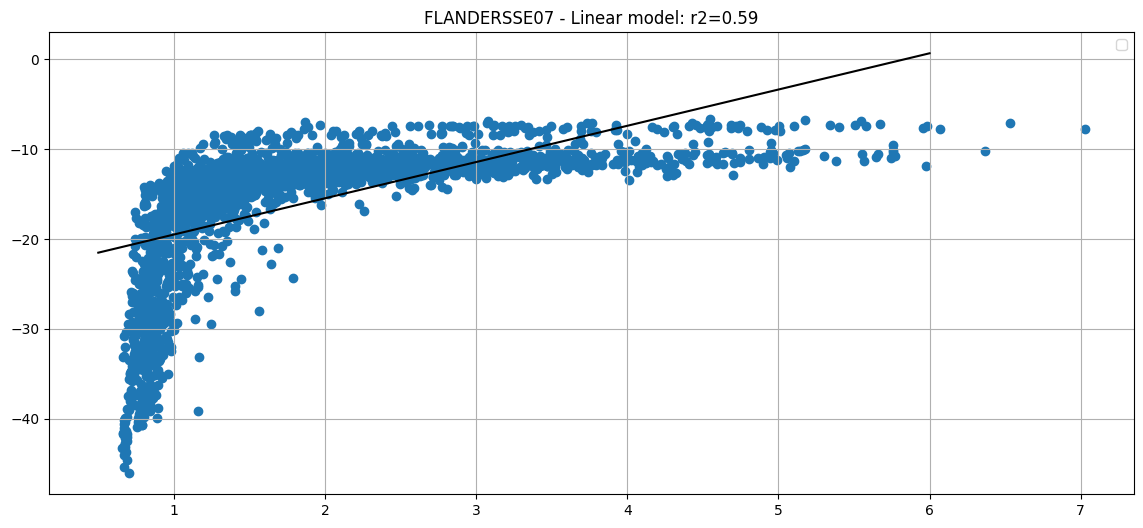

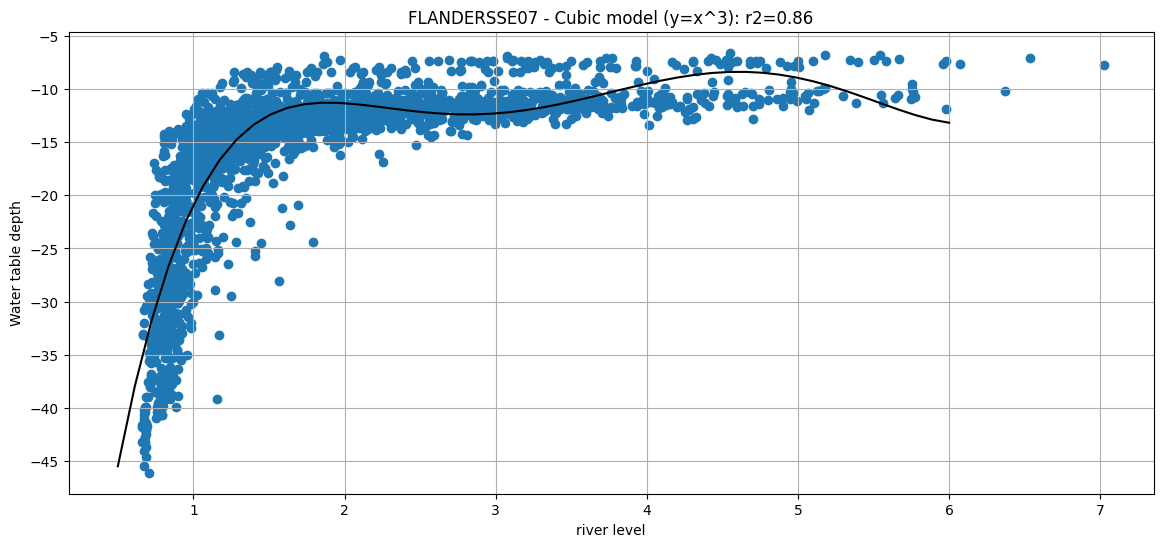

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


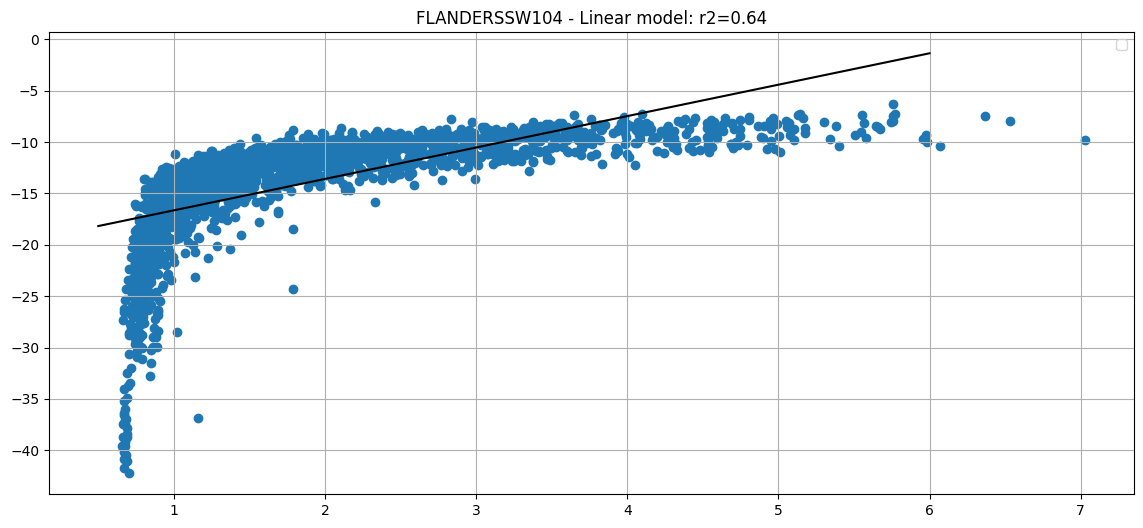

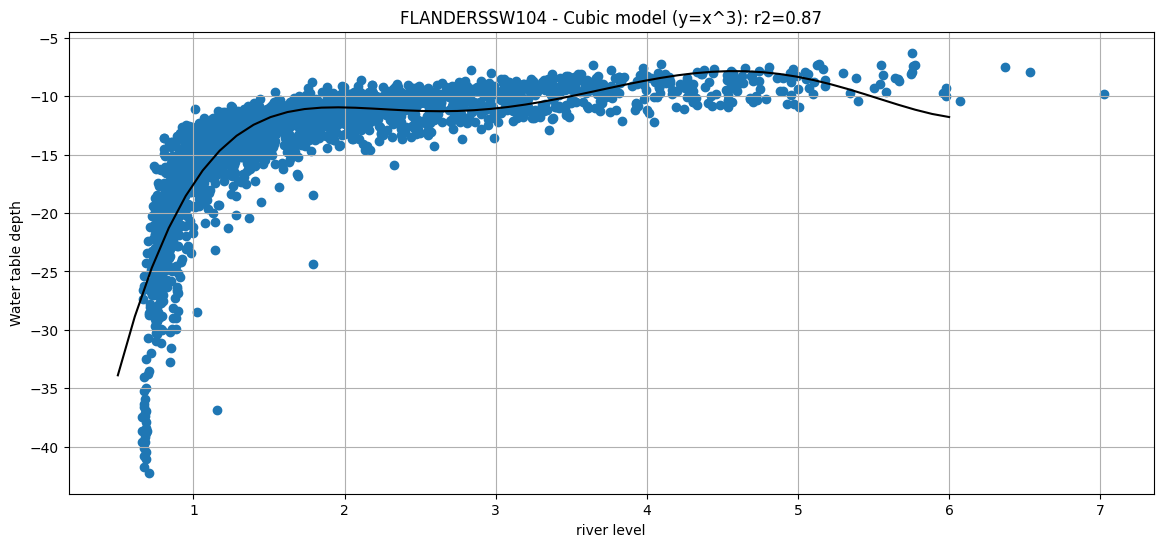

In [167]:
import numpy as np

i = 0
for i in range(aux.shape[0]):
    lat = float(aux['Lat'].iloc[i])
    lon = float(aux['Lon'].iloc[i])
    polyline = np.linspace(0.5, 6)
    # filter WTD
    log_site = Flanders_WTD[Flanders_WTD['logger']==aux['Logger name'].iloc[i]]

    level_time_series['date_obj']=pd.to_datetime(level_time_series.index.date)
    level_time_series.set_index('date_obj',inplace=True)
    df_aux_ = pd.merge(log_site, level_time_series, left_index=True, right_index=True)

    fig,(ax)=plt.subplots(nrows=1,ncols=1,figsize=(14,6))
    ax.scatter(df_aux_.Value,df_aux_.level)
    model = np.poly1d(np.polyfit(df_aux_.Value,df_aux_.level,1))
    plt.plot(polyline, model(polyline),'k')
    corr = np.corrcoef(df_aux_.Value,df_aux_.level)[1,0]
    ax.set_title(aux['Logger name'].iloc[i]+' - Linear model: r2='+str(np.round(corr,2)))
    #ax.set_ylim(-40,7)
    ax.grid(True)
    ax.legend()

    model = np.poly1d(np.polyfit(df_aux_.Value,df_aux_.level,5))
    pred = model(df_aux_.Value)
    corr_ = np.corrcoef(pred,df_aux_.level)[1,0]

    fig,(ax)=plt.subplots(nrows=1,ncols=1,figsize=(14,6))
    #add fitted cubic regression line to scatterplot
    plt.scatter(df_aux_.Value,df_aux_.level)
    plt.plot(polyline, model(polyline),'k')
    ax.set_title(aux['Logger name'].iloc[i]+' - Cubic model (y=x^3): r2='+str(np.round(corr_,2)))
    #add axis labels
    plt.xlabel('river level')
    plt.ylabel('Water table depth')
    ax.grid(True)
    #display plot
    plt.show()



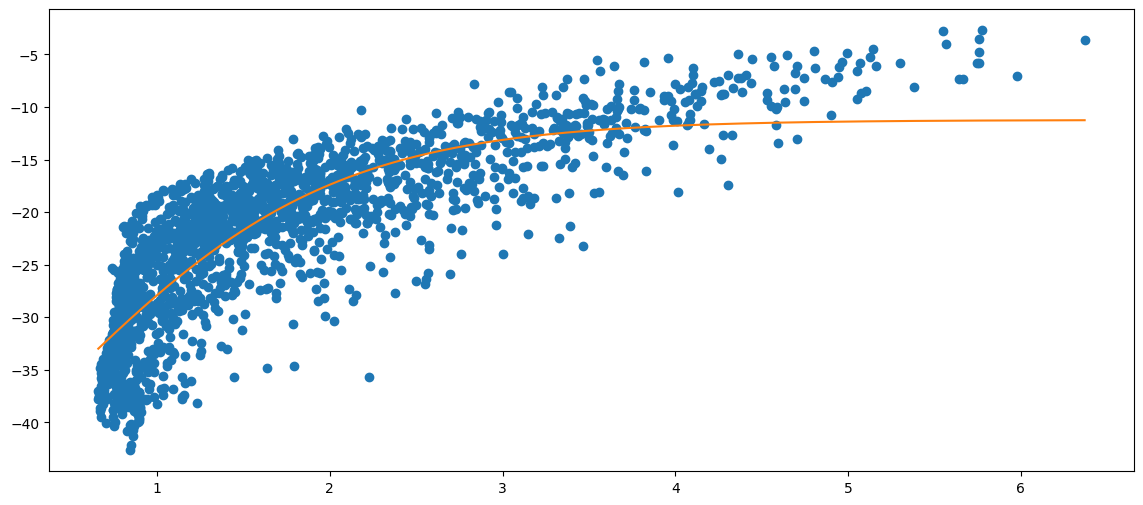

In [163]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

x = np.array(df_aux_.sort_values('Value')['Value'])
y = np.array(df_aux_.sort_values('Value')['level'])

popt, pcov = opt.curve_fit(f, x, y, bounds=((-50,-100.0,-100,-100),(50,100,100,100)),method="trf")
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.show()